# **Fragilità delle reti neurali: attivazione, gradienti e normalizzazione**
### **Sviluppo di Makemore, Parte 3**
Dennis Remigio, Novembre 2024

**Obiettivi**: migliorare l'addestramento delle reti neurali esplorando i problemi che possono presentarsi durante l'addestramento, a partire dall'inizializzazione. Introdurre il concetto di normalizzazione ed approfondire le motivazioni per voler introdurre strati di normalizzazione in vari punti della rete. Apprendere come diagnosticare lo stato di reti durante l'addestramento attraverso l'analisi di attivazioni e gradienti, fornendo strumenti pratici per ottimizzare e rendere più robusto il processo di apprendimento.

**Precompetenze**: basi di Python, comprensione della struttura delle semplici reti neurali e del loro addestramento.

&nbsp;

---

Adattamento e approfondimento della lezione di **Andrej Karpathy, PhD**: *Building makemore Part 3: Activations & Gradients, BatchNorm*, disponibile [qui](https://youtu.be/P6sfmUTpUmc?si=6rjWA_Ex-COePzZf).

---

## **Indice**

[**Introduzione**](#s0)  
[**1 - Revisione della lezione precedente**](#s1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**1.1 - Setup iniziale e preprocessing dei dati**](#s1.1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**1.2 - Preparazione del dataset**](#s1.2)  
&nbsp;&nbsp;&nbsp;&nbsp;[**1.3 - Costruzione del modello**](#s1.3)  
&nbsp;&nbsp;&nbsp;&nbsp;[**1.4 - Addestramento del modello**](#s1.4)  
&nbsp;&nbsp;&nbsp;&nbsp;[**1.5 - Valutazione del modello**](#s1.5)  
&nbsp;&nbsp;&nbsp;&nbsp;[**1.6 - Generazione di nomi**](#s1.6)  
[**2 - Problemi di Inizializzazione delle Reti Neurali**](#s2)  
&nbsp;&nbsp;&nbsp;&nbsp;[**2.1 - Analisi della perdita iniziale elevata**](#s2.1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**2.2 - Soluzioni per ridurre la perdita iniziale**](#s2.2)  
[**3 - Valori della Funzione di Attivazione**](#s3)  
&nbsp;&nbsp;&nbsp;&nbsp;[**3.1 - Analisi dei valori di tanh all'inizializzazione**](#s3.1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**3.2 - Eccessiva attività delle funzioni di attivazione: Dead Neurons**](#s3.2)  
&nbsp;&nbsp;&nbsp;&nbsp;[**3.3 - Riscalamento dei pesi**](#s3.3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[**3.3.1 - Fattore di scala dei pesi ottimale**](#s3.3.1)  
[**4 - Batch Normalization**](#s4)  
&nbsp;&nbsp;&nbsp;&nbsp;[**4.1 - Implementazione della Batch Normalization**](#s4.1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**4.2 - Batch normalization "in a nutshell"**](#s4.2)  
[**5 - Ottimizzazione della struttura del codice**](#s5)  
[**6 - Analisi approfondita senza normalizzazione**](#s6)  
&nbsp;&nbsp;&nbsp;&nbsp;[**6.1 - Attivazioni durante il forward pass**](#s6.1)  
&nbsp;&nbsp;&nbsp;&nbsp;[**6.2 - Attivazioni durante il backward pass**](#s6.2)  
&nbsp;&nbsp;&nbsp;&nbsp;[**6.3 - Rapporto tra dato e gradiente**](#s6.3)  
&nbsp;&nbsp;&nbsp;&nbsp;[**6.4 - Rapporto tra tasso di aggiornamento e dato**](#s6.4)  
[**8 - Analisi approfondita con normalizzazione**](#s7)  
&nbsp;&nbsp;&nbsp;&nbsp;[**7.1 - Test con variazione del gain**](#s7.1)  
[**Conclusioni**](#sconcl)  

<a name="s0"></a>
## **Introduzione**



In questa lezione ci concentreremo su alcuni aspetti cruciali per migliorare l'addestramento delle reti neurali, affrontando specifici problemi di inizializzazione e ottimizzazione. Ciò fornirà strumenti pratici e teorici per affrontare problemi comuni nell'addestramento delle reti neurali, migliorando le prestazioni e la stabilità del modello.

**Problemi di Inizializzazione delle Reti Neurali:**
* **Analisi della perdita iniziale elevata:** vedremo come un'errata inizializzazione dei pesi possa portare a una perdita iniziale insolitamente alta, compromettendo l'efficacia dell'addestramento.
* **Soluzioni per ridurre la perdita iniziale:** esploreremo tecniche e modifiche ai parametri iniziali per mitigare questo problema, migliorando la stabilità e le performance del modello.

**Valori della Funzione di Attivazione:**
* **Analisi dei valori di tanh all'inizializzazione:** analizzeremo come i valori della funzione tanh all'inizializzazione possano influenzare l'addestramento e la propagazione del gradiente.
* **Eccessiva attività delle funzioni di attivazione:** discuteremo il fenomeno dei "dead neurons", in cui i neuroni non si attivano durante l'addestramento, e come questo problema possa essere prevenuto.

**Riscalamento dei Pesi:**
* **Fattore di scala dei pesi ottimale:** determineremo il fattore di scala ottimale per i pesi, utilizzando tecniche per mantenere una distribuzione bilanciata dei valori.

**Batch Normalization:**
* **Implementazione della Batch Normalization:** implementeremo la Batch Normalization per migliorare la stabilità dell'addestramento, normalizzando i valori passati alla funzione di attivazione per ottenere distribuzioni gaussiane.

**Diagnostica:**
* Esamineremo alcune tecniche per analizzare il comportamento della rete sotto diversi aspetti, in modo da assicurarci che l'addestramento avvenga in maniera ottimale.


<a name="s1"></a>
## **1 - Revisione della lezione precedente**

<a name="s1.1"></a>
### **1.1 - Setup iniziale e preprocessing dei dati**

Riprendiamo da dove era terminata la scorsa lezione.

Importiamo le librerie fondamentali:

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

Importiamo il dataset:

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-10-25 08:12:41--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-10-25 08:12:41 (6.34 MB/s) - ‘names.txt’ saved [228145/228145]



Creiamo la lista con tutti i nomi, a partire dal dataset di input:

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

Effettuiamo un basilare encoding dei caratteri, trasformandoli in numeri:

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


<a name="s1.2"></a>
### **1.2 - Preparazione del dataset**

Costruiamo i dataset di train , dev e test, ovvero gli esempi `X` e le etichette `Y` (che dipendono dal numero di caratteri scelti come contesto):



In [ ]:
block_size = 3 # lunghezza del contesto: quanti caratteri teniamo in considerazione per prevedere il successivo?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


<a name="s1.3"></a>
### **1.3 - Costruzione del modello**

Creiamo la rete definita nella lezione precedente, questa volta in maniera più ordinata (rimuovendo i numeri "hard coded" e creando invece variabili che permettono di modificare facilmente i valori, per poter effettuare alcune prove in maniera più semplice).

In [ ]:
# iperparametri
n_embd = 10 # dimensionalità dell'embedding layer
n_hidden = 200 # numero di neuroni presenti nello strato nascosto

g = torch.Generator().manual_seed(2147483647) # seed per garantire la riproducibilità
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # numero di parametri
for p in parameters:
  p.requires_grad = True

11897


<a name="s1.4"></a>
### **1.4 - Addestramento del modello**

Scriviamo il codice per l'addestramento, anche in questo caso effettuando delle piccole migliorie rispetto alla lezione precedente (nulla di sostanziale, principalmente per rendere più rapide eventuali modifiche e rendere più chiaro il tutto):

In [ ]:
# stessa ottimizzazione della lezione precedente
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creazione del mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  ## forward pass
  emb = C[Xb] # embedding dei caratteri in vettori
  embcat = emb.view(emb.shape[0], -1) # concatenazione dei vettori
  hpreact = embcat @ W1 + b1 # strato nascosto pre attivazione
  h = torch.tanh(hpreact) # strato nascosto (passando hpreact per la funzione di attivazione)
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # funzione di perdita

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # aggiornamento dei gradienti
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # tracciamento delle statistiche
  if i % 10000 == 0: # print della perdita ogni 10000 iterazioni
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 27.8817
  10000/ 200000: 2.9415
  20000/ 200000: 2.5069
  30000/ 200000: 2.7998
  40000/ 200000: 2.0261
  50000/ 200000: 2.5863
  60000/ 200000: 2.3420
  70000/ 200000: 2.0952
  80000/ 200000: 2.3454
  90000/ 200000: 2.2365
 100000/ 200000: 2.1080
 110000/ 200000: 2.3831
 120000/ 200000: 1.9898
 130000/ 200000: 2.4591
 140000/ 200000: 2.1910
 150000/ 200000: 2.1606
 160000/ 200000: 2.1811
 170000/ 200000: 1.7997
 180000/ 200000: 2.0962
 190000/ 200000: 1.8052


Osserviamo il grafico della perdita:

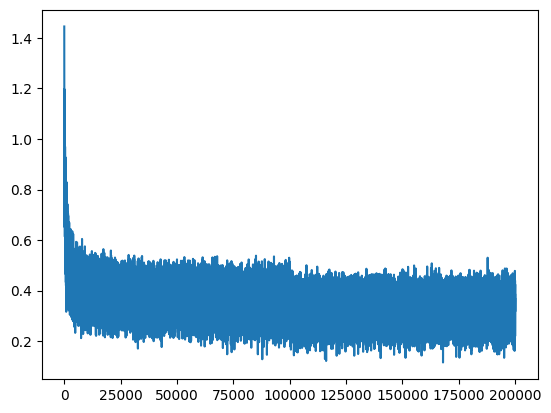

In [ ]:
plt.plot(lossi)

Fare caso alla perdita iniziale che, rispetto alle iterazioni successive dell'addestramento, è molto elevata. Ci torneremo tra poco.

<a name="s1.5"></a>
### **1.5 - Valutazione del modello**

Calcolo della perdita nei datasets di train e validation.

Il codice è scritto, anche in questo caso, in maniera più efficiente rispetto alla lezione precedente, creando una funzione che permetterà poi di scegliere quale perdita si vuole osservare.

Appena prima della funzione `split_loss()` è stato inserito il decoratore `@torch.no_grad()`, il cui scopo è fare in modo che, quando viene chiamata la funzione `split_loss()`, il codice non salvi informazioni sui gradienti. Normalmente registrerebbe in memoria un grafo di tutti i calcoli, (in maniera simile a quanto abbiamo visto nella lezione in cui abbiamo creato `micrograd`), supponendo che in seguito verrà chiamata la funzione `.backward` per effettuare la back propagation. Poiché, invece, non ci interessa addestrare la rete su questa ultima iterazione (visto che ci serve solamente per valutare le prestazioni del modello), possiamo evitare di far creare tutta questa memoria.

In [ ]:
@torch.no_grad() # il decoratore fa in modo di non far tenere traccia dei gradienti
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.127678871154785
val 2.1750576496124268


<a name="s1.6"></a>
### **1.6 - Generazione di nomi**

Infine, il codice per la generazione dei nomi:

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # inizializza con "..."
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # genera a partire dalla distribuzione di probabilità
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # sposta la finestra di contesto e traccia le generazioni
      context = context[1:] + [ix]
      out.append(ix)
      # se viene generato '.', break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # effettua il decoding ed effettua il print delle parole generate

mora.
mayah.
seel.
nehayla.
remyra.
endrael.
adeer.
melin.
shy.
jen.
ede.
seananaraelyn.
malya.
cayshubergiaghan.
trickontelionnie.
cayus.
mace.
ryyah.
fael.
youe.


I nomi generati non sono ancora perfetti, ma sono decisamente migliori rispetto a quelli generati dal modello Bigram.

<a name="s2"></a>
## **2 - Problemi di Inizializzazione delle Reti Neurali**



<a name="s2.1"></a>
### **2.1 - Analisi della perdita iniziale elevata**

Come notato poco fa, la perdita iniziale è elevatissima, in effetti è addirittura più alta di quello che ci si aspetterebbe da un modello che assegna a tutti i caratteri uguale probabilità di essere scelti. Possiamo infatti vedere che, in tale caso, la perdita sarebbe molto inferiore:

In [ ]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

*È buona norma, nello sviluppo di modelli di intelligenza artificale, avere una idea generale della perdita che dovrebbe esserci all'inizializzazione (ovviamente, il valore effettivo della perdita dipende anche dalla funzione di perdita scelta).*

Come previsto, la perdita calcolata in maniera casuale risulta decisamente più bassa (precedentemente era di `27.8817`, ora è di `3.2958`).  

Questo fenomeno è dovuto al fatto che all'inizializzazione il modello non assegna pesi uguali a tutti i caratteri ma, invece, assegna (in maniera casuale) un peso maggiore ad alcuni caratteri rispetto ad altri, generando una perdita potenzialmente molto elevata.  

&nbsp;

---

Possiamo osservare questo fenomeno in maniera intuitiva, tramite un rapido esempio.

* Consideraimo un vettore composto solamente da 4 elementi.  

* Di questi 4 elementi, consideriamo come "label" da indovinare per il carattere successivo l'indice `2` (ovvero il terzo elemento).

Come primo esempio, vediamo cosa accade se i logits, sono tutti uguali (metaforicamente, stiamo considerando che in una cesta sono presenti un uguale numero di elementi con etichetta `0`, rispetto a quelli con etichetta `1`, `2` e `3`, quindi la probabilità di pescare l'elemento con etichetta `2` sarà un quarto):

In [ ]:
logits = torch.tensor([12.0, 12.0, 12.0, 12.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # probabilità di pescare, ad esempio, il terzo valore come successivo
logits, probs, loss

(tensor([12., 12., 12., 12.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

Considerando come label (ovvero la risposta corretta da individuare) l'indice `2`, visto che i logits erano tutti uguali, il modello può pescarlo con `1/4` di probabilità, poiché assegna ad ogni elemento la stessa probabilità di essere pescato.

Ipotizziamo ora che il modello, all'inizializzazione (che avviene in modo casuale), assegna un numero molto alto proprio al terzo elemento (indicando, metaforicamente, che nella cesta ci siano molti più elementi con il label `2` rispetto agli altri elementi):

In [ ]:
logits = torch.tensor([12.0, 12.0, 20.0, 12.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([12., 12., 20., 12.]),
 tensor([3.3513e-04, 3.3513e-04, 9.9899e-01, 3.3513e-04]),
 tensor(0.0010))

Possiamo vedere che il modello in questo caso ha una perdita molto bassa (poiché è molto più probabile che peschi proprio l'elemento più frequente nella "cesta").

Considerando che l'inizializzazione avviene in maniera casuale (e che gli esempi sono decisamenente più di 4), è molto improbabile che ciò accada. È molto più probabile, invece, che accada il contrario, ovvero che altri elementi ricevano valori dei logits più elevati.

In [ ]:
g = torch.Generator().manual_seed(21474836) # per rendere l'esempio ripetibile
logits = torch.randn(4, generator=g)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 0.8723,  1.3809, -0.6681, -0.3643]),
 tensor([0.3157, 0.5250, 0.0677, 0.0917]),
 tensor(2.6933))

Possiamo vedere che, anche solamente generando in maniera casuale (è possibile rimuovere `g` e testare ripetute volte per ottenere una riconferma), si può vedere che l'errore tende ad essere maggiore, ma non di molto.

Un aumento drastico della perdita accade quando i conteggi aumentano.

Utilizzando lo stesso esempio, proviamo ad aumentare i conteggi manualmente:

In [ ]:
g = torch.Generator().manual_seed(21474836) # per rendere l'esempio ripetibile
logits = torch.randn(4, generator=g) * 20 # aumento dei conteggi
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 17.4459,  27.6174, -13.3614,  -7.2866]),
 tensor([3.8242e-05, 9.9996e-01, 1.5963e-18, 6.9401e-16]),
 tensor(40.9788))

Si può osservare che la perdita ha raggiunto valori elevatissimi.

In alcuni casi, per conteggi molto elevati, la perdita può raggiungere anche valori infiniti.

Il nostro obiettivo, quindi, è fare in modo che i logits generati dalla rete neurale in fase di inizializzazione siano più vicini a zero.

---

<a name="s2.2"></a>
### **2.2 - Soluzioni per ridurre la perdita iniziale**

Nel nostro caso, i logits vengono attualmente calcolati come segue:



```
logits = h @ W2 + b2
```

Quindi possiamo ridurre il valore all'inizializzazione tramite due aggiustamenti:

1. Ponendo `b2 = 0`
2. Riducendo il valore di `W2`

In [ ]:
# iperparametri
n_embd = 10 # dimensionalità dell'embeddin layer
n_hidden = 200 # numero di neuroni presenti nello strato nascosto

# parametri all'inizializzazione
g = torch.Generator().manual_seed(2147483647) # seed per garantire la riproducibilità
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # ridurre il valore di W2
b2 = torch.randn(vocab_size,                      generator=g) * 0 # b2 = 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # numero di parametri
for p in parameters:
  p.requires_grad = True

11897


Effettuiamo un ciclo di forward pass per individuare la perdita all'inizializzazione:

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creazione del mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  ## forward pass
  emb = C[Xb] # embedding dei caratteri in vettori
  embcat = emb.view(emb.shape[0], -1) # concatenazione dei vettori
  hpreact = embcat @ W1 + b1 # strato nascosto pre attivazione
  h = torch.tanh(hpreact) # strato nascosto (passando hpreact per la funzione di attivazione)
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # funzione di perdita

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # aggiornamento dei gradienti
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # tracciamento delle statistiche
  if i % 10000 == 0: # print della perdita ogni 10000 iterazioni
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break # per interrompere dopo un solo ciclo, in modo da vedere la perdita solo all'inizializzazione

      0/ 200000: 3.3221


Come possiamo vedere, la perdita all'inizializzazione è decisamente più bassa.

&nbsp;

---

Avremmo potuto impostare il valore di `W2` a `0` per ottenere una perdita ancora più bassa all'inizializzazione, ma esporrebbe a diversi problemi, che avvronteremo più in la in questa lezione.

---

&nbsp;

Possiamo ora osservare graficamente l'andamento della perdita nel corso dell'intero addestramento (dopo aver resettato i parametri). Vedremo che non presenterà più il picco iniziale.

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creazione del mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  ## forward pass
  emb = C[Xb] # embedding dei caratteri in vettori
  embcat = emb.view(emb.shape[0], -1) # concatenazione dei vettori
  hpreact = embcat @ W1 + b1 # strato nascosto pre attivazione
  h = torch.tanh(hpreact) # strato nascosto (passando hpreact per la funzione di attivazione)
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # funzione di perdita

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # aggiornamento dei gradienti
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # tracciamento delle statistiche
  if i % 10000 == 0: # print della perdita ogni 10000 iterazioni
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.1857
  10000/ 200000: 1.8700
  20000/ 200000: 1.9252
  30000/ 200000: 2.0570
  40000/ 200000: 2.2073
  50000/ 200000: 2.1325
  60000/ 200000: 2.1533
  70000/ 200000: 2.8029
  80000/ 200000: 2.6544
  90000/ 200000: 2.2931
 100000/ 200000: 2.2813
 110000/ 200000: 1.8629
 120000/ 200000: 2.1695
 130000/ 200000: 1.9693
 140000/ 200000: 1.8043
 150000/ 200000: 2.4483
 160000/ 200000: 2.2238
 170000/ 200000: 1.7788
 180000/ 200000: 1.9207
 190000/ 200000: 2.1601


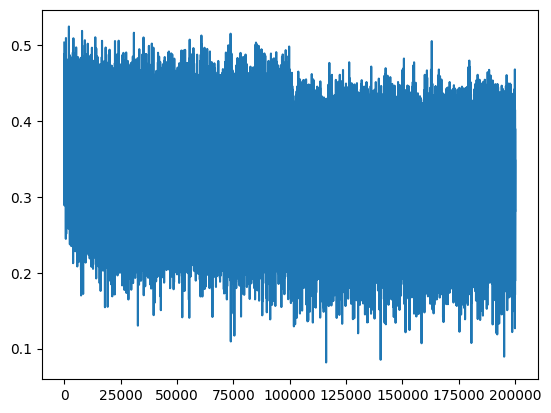

In [ ]:
plt.plot(lossi)

Prima di effettuare questo processo, nelle prime iterazioni il modello schiacciava i pesi per avvicinarli a zero, e solo poi tentava di ottimizzare.

<a name="s3"></a>
## **3 - Valori della Funzione di Attivazione**

In questo capitolo osserveremo il comportamento della funzione di attivazione, che ha un impatto molto importante sulla capacità della rete di addestrarsi in maniera efficace.

<a name="s3.1"></a>
### **3.1 - Analisi dei valori di `tanh` all'inizializzazione**

Iniziamo osservando i valori della funzione di attivazione `tanh` all'inizializzazione.

Innanzitutto reimpostiamo i parametri della rete:

In [ ]:
# iperparametri
n_embd = 10 # dimensionalità dell'embeddin layer
n_hidden = 200 # numero di neuroni presenti nello strato nascosto

# parametri all'inizializzazione
g = torch.Generator().manual_seed(2147483647) # seed per garantire la riproducibilità
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # ridurre il valore di W2
b2 = torch.randn(vocab_size,                      generator=g) * 0 # b2 = 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # numero di parametri
for p in parameters:
  p.requires_grad = True

11897


Per creare il grafico di `h` utilizziamo `viev()` per schiacciare i valori in una unica dimensione (utilizzando `-1` senza indicare una seconda dimensione, riempirà automaticamente i valori per ottenere il numero corretto di elementi, nel nostro caso `32*200`)

In [ ]:
print(h.shape)
print(h.view(-1).shape)

torch.Size([32, 200])
torch.Size([6400])


Creiamo il grafico, esso mostrerà sull'asse verticale il numero di elementi, mentre sull'asse orizzontale sarà indicato i valori effettivi.

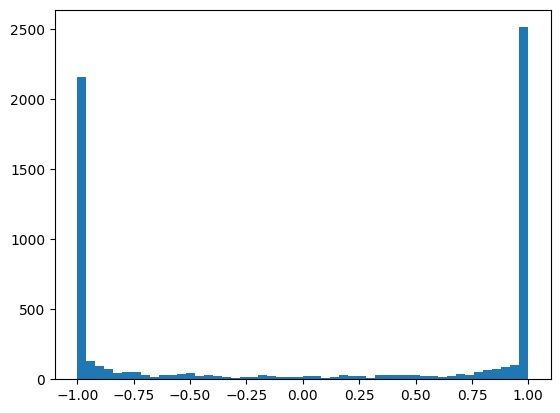

In [ ]:
plt.hist(h.view(-1).tolist(), 50); # 50 indica il numero di colonne del grafico

Il grafico mostra che, dopo l'applicazione della funzione di attivazione tanh, i valori risultano distribuiti quasi esclusivamente intorno a `-1` e `1`. Ricordando che questa funzione comprime i valori d'ingresso nell'intervallo `[-1, 1]`, possiamo dedurre che l'attivazione è stata molto intensa: la funzione ha compresso la maggior parte dei valori (che, quindi, erano decisamente fuori dall'intervallo `[-1, 1]`), portandoli ai limiti dell'intervallo, ovvero `-1` e `1`.

Possiamo confermare questa ipotesi osservando gli output prima che passino per l'attivazione.

Creiamo il grafico, che anche in questo caso mostrerà sull'asse verticale il numero di elementi, mentre sull'asse orizzontale i valori effettivi.

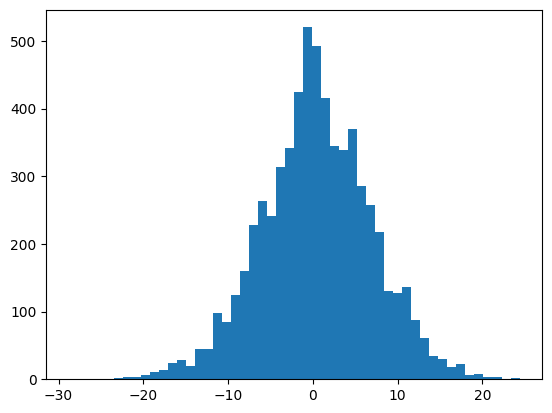

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50); # 50 indica il numero di colonne del grafico

Come previsto, l'intervallo dei valori in ingresso alla funzione di attivazione è molto esteso, con la maggior parte degli elementi che presenta valori, in valore assoluto, ben superiori a `1`.

Questo aspetto, anche se inizialmente può non sembrare problematico, si rivela in realtà cruciale, e ora vedremo il perché, tornando all'implementazione della funzione tanh in `micrograd`:
```
    def tanh(self): # definizione della funzione per gestire la funzione di attivazione
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad # derivata della funzione tanh

        out._backward = _backward

        return out
```

Durante il backward pass, come possiamo osservare, il gradiente dell'output viene moltiplicato per la derivata parziale di `tanh`, ossia `(1.0 - t**2)`. Ora, immaginiamo cosa accadrebbe se `tanh` assumesse solo i valori `-1` e `1`: in tal caso, il gradiente si annullerebbe, bloccando la backpropagation.

Al contrario, se `tanh` fosse pari a zero, `out.grad` passerebbe direttamente, senza che `tanh` interferisca con il flusso dei gradienti. Questo ci offre una visione intuitiva del ruolo di questa funzione: attraversando il layer di attivazione, il gradiente può solo ridursi.

&nbsp;

---

A questa deduzione si poteva arrivare anche ragionando sul grafico di `tanh`.

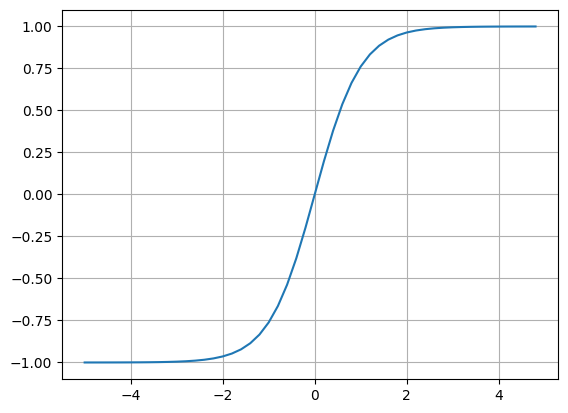

In [ ]:
plt.plot(torch.arange(-5,5,0.2), torch.tanh(torch.arange(-5,5,0.2))); plt.grid();

Se i valori sono schiacciati a `-1` o `1`, significa che dopo essere passati per la funzione di attivazione si trovano alle estremità della curva, dove la funzione è praticamente piatta (il valore sull'asse verticale resta invariato al variare dell'asse orizzontale, quindi sono sostanzialmente costanti). Questo indica che i parametri non influenzano la perdita, e quindi il gradiente è nullo.

&nbsp;

---

Ora approfondiremo come questo aspetto possa rivelarsi ancor più grave di quanto sia intuitivamente deducibile.

<a name="s3.2"></a>
### **3.2 - Eccessiva attività delle funzioni di attivazione: "Dead Neurons"**

Creiamo un grafico a scacchiera che mostra la distribuzione dei valori dopo essere passati per la funzione di attivazione `tanh`. I valori che rappresenteremo nel grafico saranno rappresentati i `200` neuroni di input, di cui ciascuno verìdrà `32` esempi (`32` è dato dalla dimensione del batch)

Nel grafico, saranno indicati con il colore nero i valori che sono all'interno dell'intervallo `(-1, 1)` (estremi non compresi), e con il colore bianco i valori che sono stati schiacciati al valore `-1` o `1` (su cui, quindi, come abbiamo visto poco fa, non agisce più il gradiente).

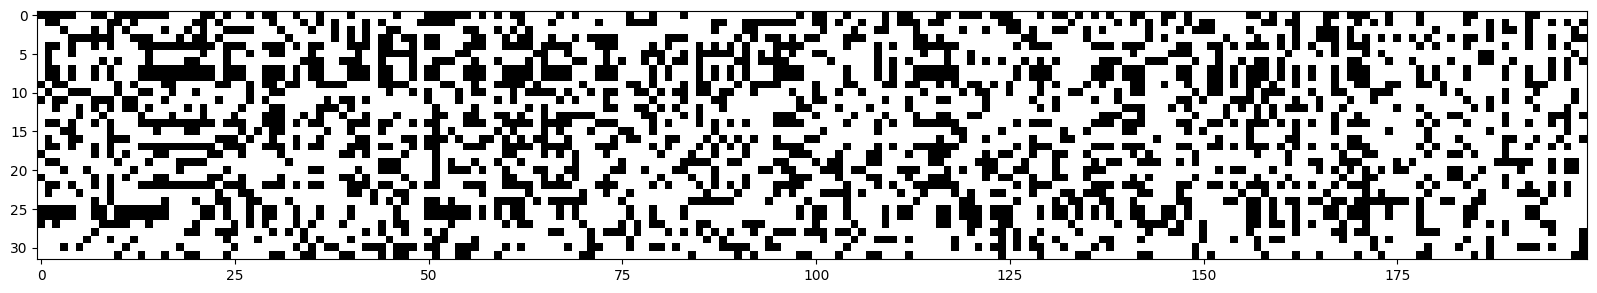

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # bianco se è vero, nero se è falso

In tutte le zone bianche, il gradiente è stato completamente annullato dalla funzione `tanh`, rendendo nullo l'effetto del gradiente sui valori.

Se una colonna risultasse interamente bianca, ciò indicherebbe che, a causa dei valori di inizializzazione dei pesi e dei bias, nessuno degli esempi riesce ad attivare la funzione tanh nella sua zona "attiva" (all'interno dell'intervallo `(-1, 1)`). Di conseguenza, durante la backpropagation, il gradiente non avrebbe alcun effetto su quel neurone, che non imparerebbe mai. Questa situazione viene definita "dead neuron": un neurone che non si attiva mai e quindi non apprende.

Questo problema può verificarsi casualmente all'inizializzazione, ma anche durante l'addestramento, soprattutto con learning rate molto elevati. In tali casi, i neuroni possono ricevere gradienti così intensi da portarli fuori dall’intervallo attivo della funzione di attivazione, disattivandoli completamente e impedendo la loro riattivazione nel corso dell’addestramento.

&nbsp;

---

Questo problema si verifica per molte funzioni di attivazione:

1. Sigmoide: presenta lo stesso problema della `tanh`.

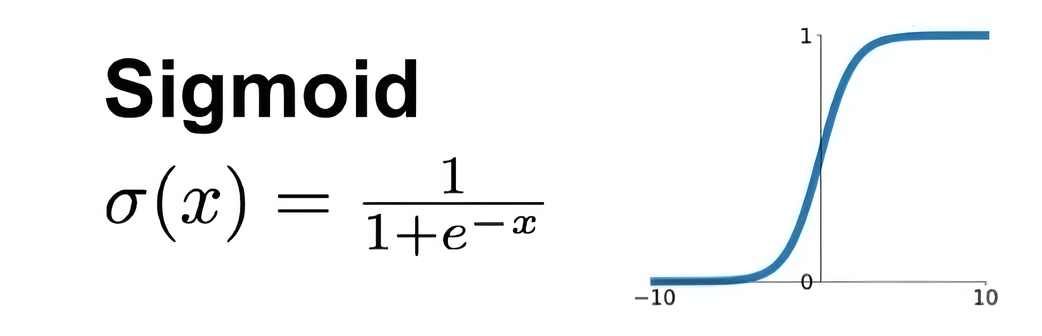

2. ReLU: il problema si verificherebbe nel caso in cui i valori fossero tutti minori di zero. In questo caso la funzione azzererebbe il valore e quindi non farebbe propagare i gradienti, generando un "dead neuron".

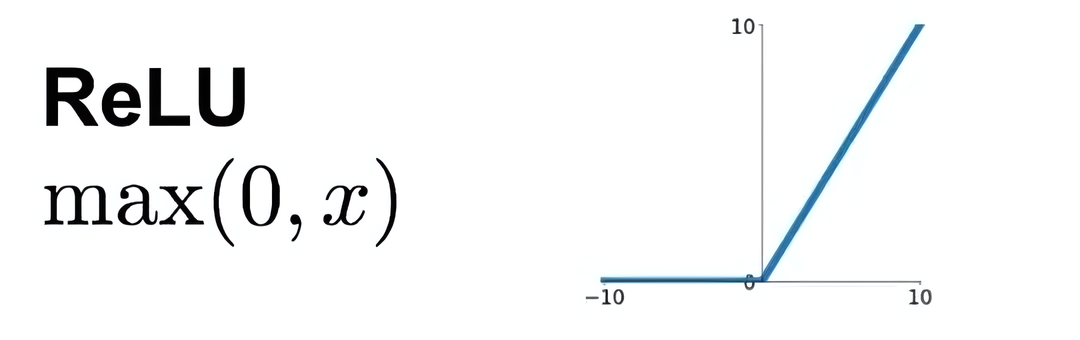

3. Leaky ReLU: non ha questo problema perché non ha una coda piatta.

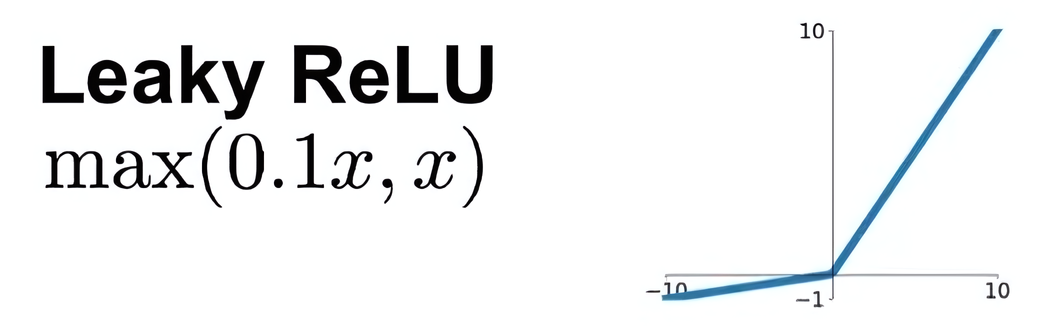

4. ELU: soffre lo stesso problema di ReLU.

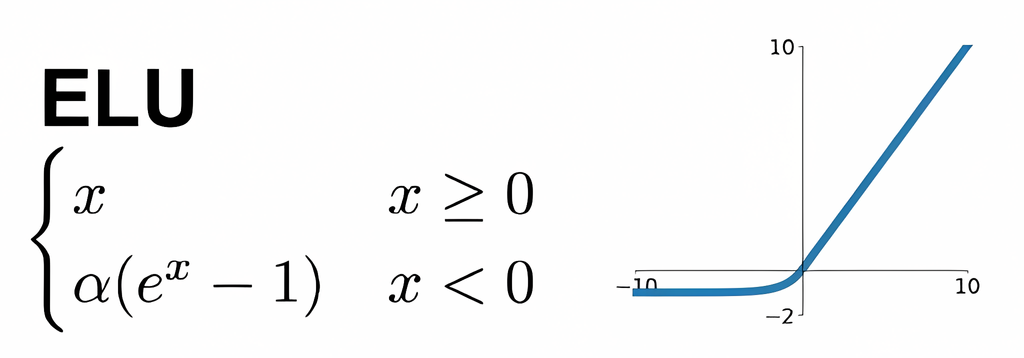

---

<a name="s3.3"></a>
### **3.3 - Riscalamento dei pesi**

Sebbene nel nostro caso non ci siano dei neuroni spenti, è comunque buona pratica mandare alla funzione `tanh` dei valori più piccoli, in modo da non avere una attivazione così forte, poiché avere come output della `tanh` valori così agli estremi della funzione fa si che la rete apprenda molto più lentamento (la rete si addestra meno, visto che ci sono poche attivazioni).

All'attivazione arrivano valori da `hpreact`. Similarmente a quanto fatto per `W2` e `b2`, dobbiamo fare in modo di far avvicinare più il valore allo zero, riducendo il valore dei parametri che compongono `hpreact`, ovvero `W1` e `b1`.
Schiacceremo i pesi di un fattore `5` (il valore è stato scelto per fare in modo che i valori fossero quasi tutti tra `-1` e `1`, ma non tutti. Si può vedere facilmente facendo qualche tentativo e osservando i grafici delle attivazioni. *Ovviamente non è il metodo utilizzato nella pratica, in quanto esistono metodi decisamente più efficienti rispetto a scegliere "numeri magici" scelti dopo qualche tentativo manuale*), mentre i bias di un fattore 100 (invece di rimuoverli completamente, può essere utile averli con un valore basso, introdurre un minimo di entropia nel sistema può aiutare il processo di ottimizzazione).

In [ ]:
# iperparametri
n_embd = 10 # dimensionalità dell'embeddin layer
n_hidden = 200 # numero di neuroni presenti nello strato nascosto

# parametri all'inizializzazione
g = torch.Generator().manual_seed(2147483647) # seed per garantire la riproducibilità
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # ridurre il valore di W1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # ridurre il valore di b1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # ridurre il valore di W2
b2 = torch.randn(vocab_size,                      generator=g) * 0 # b2 = 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # numero di parametri
for p in parameters:
  p.requires_grad = True

11897


Proviamo ora a vedere i grafici di `tanh`.

Per poter generare i grafici aggiornati, rieseguiamo l'addestramento per un primo batch.

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creazione del mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  ## forward pass
  emb = C[Xb] # embedding dei caratteri in vettori
  embcat = emb.view(emb.shape[0], -1) # concatenazione dei vettori
  hpreact = embcat @ W1 + b1 # strato nascosto pre attivazione
  h = torch.tanh(hpreact) # strato nascosto (passando hpreact per la funzione di attivazione)
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # funzione di perdita

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # aggiornamento dei gradienti
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # tracciamento delle statistiche
  if i % 10000 == 0: # print della perdita ogni 10000 iterazioni
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break # per interrompere dopo un solo ciclo, in modo da vedere la perdita solo all'inizializzazione

      0/ 200000: 3.3135


Possiamo ora vedere i grafici aggiornati:

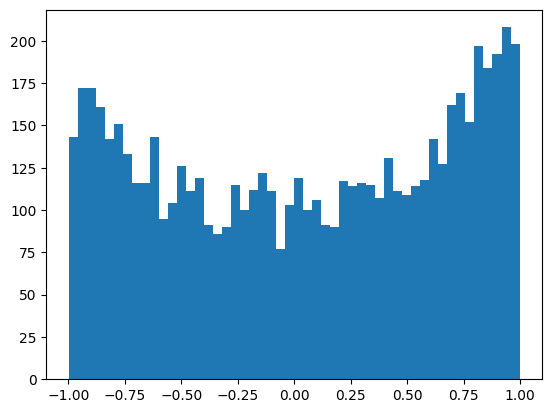

In [ ]:
plt.hist(h.view(-1).tolist(), 50); # 50 indica il numero di colonne del grafico

Possiamo vedere come la distribuzione non sia completamente concentrata sugli estremi.

Per riconferma, possiamo anche vedere il grafico dei valori che vengono mandati alla funzione di attivazione:

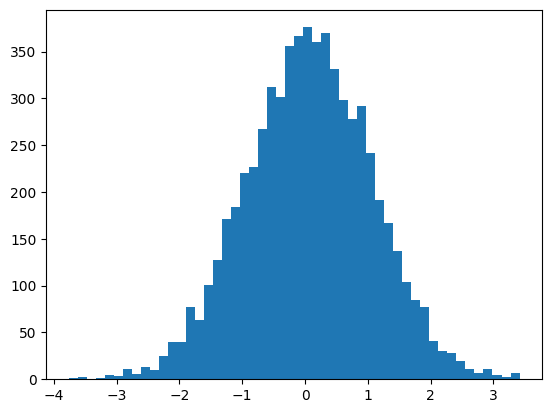

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50); # 50 indica il numero di colonne del grafico

Infatti i valori non sono più tra `-20` e `20`, ma tra `-3` e `3`.

Ci aspettiamo che il grafico delle attivazioni abbia molte meno parti bianche:

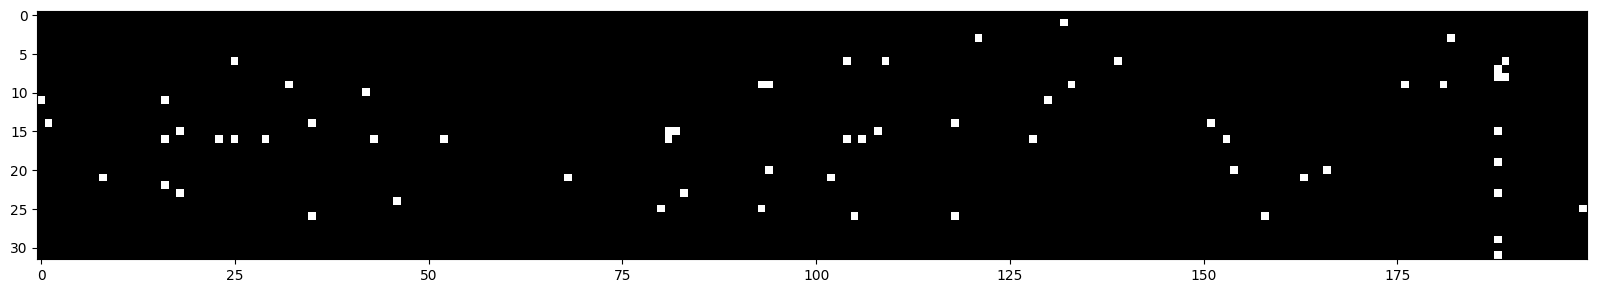

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # bianco se è vero, nero se è falso

Se avessimo ridotto `W1` di un fattore 10, il grafico sarebbe stato completamente nero.

Possiamo effettuare l'addestramento nuovamente, e calcolare la perdita:

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creazione del mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  ## forward pass
  emb = C[Xb] # embedding dei caratteri in vettori
  embcat = emb.view(emb.shape[0], -1) # concatenazione dei vettori
  hpreact = embcat @ W1 + b1 # strato nascosto pre attivazione
  h = torch.tanh(hpreact) # strato nascosto (passando hpreact per la funzione di attivazione)
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # funzione di perdita

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # aggiornamento dei gradienti
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # tracciamento delle statistiche
  if i % 10000 == 0: # print della perdita ogni 10000 iterazioni
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


In [ ]:
@torch.no_grad() # il decoratore fa in modo di non far tenere traccia dei gradienti
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0357086658477783
val 2.102949380874634


L'addestramento ha ora prodotto una perdita inferiore, grazie al fatto che le iterazioni sono state più efficaci, evitando una fase iniziale di compressione della matrice dei pesi.

Tuttavia, osservando i risultati, notiamo che non differiscono significativamente da quelli precedenti, suggerendo che questo processo non fosse strettamente necessario. In pratica, però, questo problema può essere molto dannoso, fino a impedire completamente l'addestramento di alcune reti. Nel nostro esempio, trattandosi di una rete semplice e di dimensioni ridotte, è comunque riuscita a ottenere risultati discreti anche senza queste precauzioni.

<a name="s3.3.1"></a>
#### **3.3.1 - Fattore di scala dei pesi ottimale**

Vediamo ora come determinare il giusto tasso di riduzione dei valori dei parametri, evitando di dover fare numerosi tentativi per trovare un valore ottimale.

Prima di fare modifiche alla nostra rete, cerchiamo di capire bene cosa vogliamo ottenere.

Creiamo una nuova rete di esempio, che ci permetterà di capire in maniera più intuitiva cosa intendiamo per "fattore di scala dei pesi ottimale".

La rete sarà composta da due strati:
- Strato di input: composto da 1000 neuroni, ciascuno di 10 dimensioni. Valori scelti casualmente con una distribuzione gaussiana  con media `0` e deviazione standard `1`
- Strato di pesi: composto da 200 neuroni, che ricevono 10 input ciascuno. Valori scelti casualmente con una distribuzione gaussiana con media `0` e deviazione standard `1`

Si calcola quindi il valore `y` di preattivazione tramite la moltiplicazione vettoriale tra `x` e `w` (per semplicità omettiamo il bias).

tensor(0.0002) tensor(0.9923)
tensor(0.0131) tensor(3.1464)


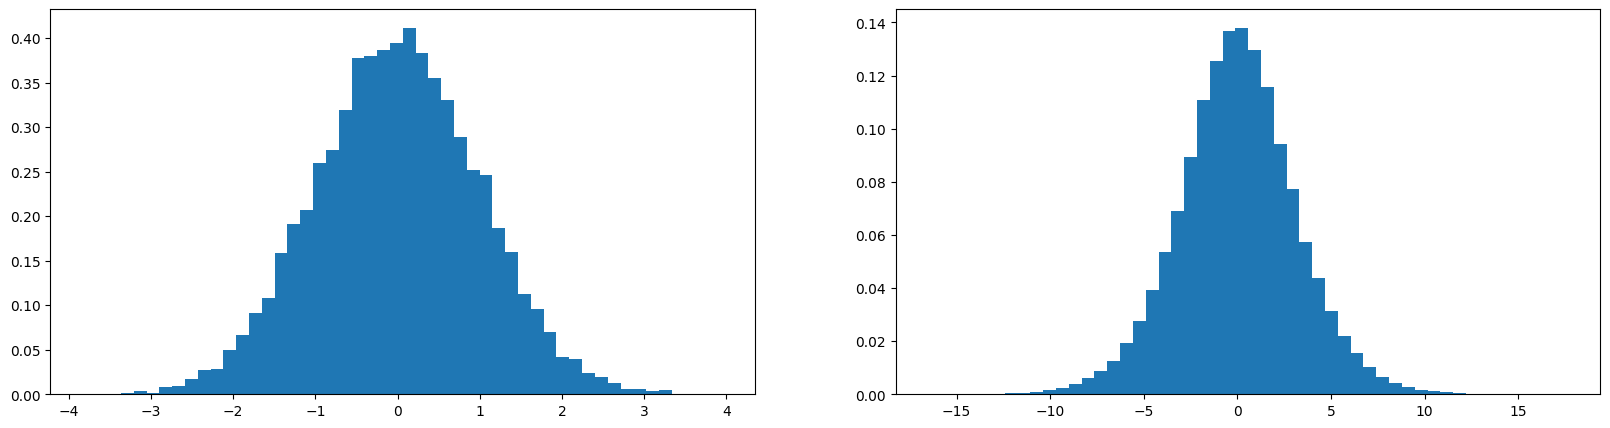

In [ ]:
x = torch.randn(1000, 10) # input layer
w = torch.randn(10, 200) # weight layer
y = x @ w # valore di preattivazione
print(x.mean(), x.std()) # media e deviazione standard di x
print(y.mean(), y.std()) # media e deviazione standard di y

# Grafici
plt.figure(figsize=(20, 5))
plt.subplot(121) # questo e il seguente subplot fanno in modo di ottenere due grafici separati
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Anche se `x` e `w` sono entrambi valori scelti casualmente tramite una distribuzione gaussiana con media `0` e deviazione standard `1`, la loro moltiplicazione vettoriale fa sì che il risultato abbia sempre una media pari a `0`, ma una deviazione standard maggiore (ovvero, la curva si è allargata, raggiungendo valori ben più grandi rispetto ad `x`, *osservare i valori sull'asse orizzontale per rendersene conto*).

La curva si allarga all'aumentare di `w`, e diminuisce al diminuire di `w`. Il nostro obiettivo è fare in modo che `y` abbia la stessa media e deviazione standard di `x`.

Invece di cercare sempre il valore corretto tramite diversi tentativi, è stato scoperto, sperimentalmente, che ciò può essere raggiunto dividendo per la radice quadrata della `fan in` (ovvero dal numero di input che riceve ogni neurone).

tensor(-0.0034) tensor(0.9972)
tensor(0.0030) tensor(1.0165)


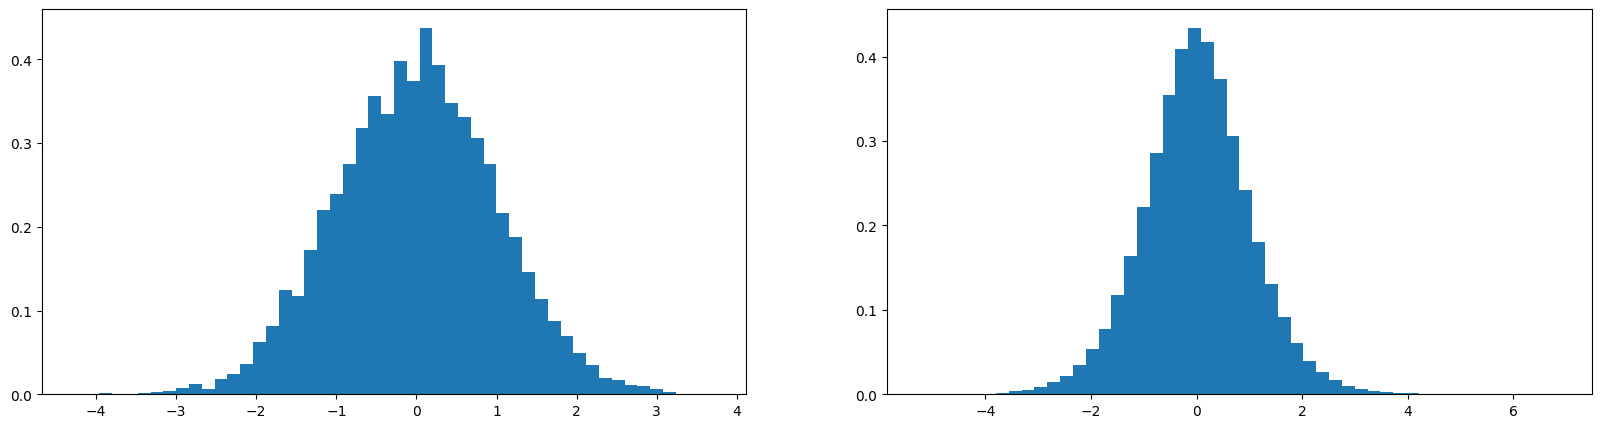

In [ ]:
x = torch.randn(1000, 10) # input layer
w = torch.randn(10, 200) / 10**0.5 # weight layer, divisi per la radice quadrata di 10 (fan in)
y = x @ w # valore di preattivazione
print(x.mean(), x.std()) # media e deviazione standard di x
print(y.mean(), y.std()) # media e deviazione standard di y

# Grafici
plt.figure(figsize=(20, 5))
plt.subplot(121) # questo e il seguente subplot fanno in modo di ottenere due grafici separati
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Possiamo infatti vedere che la deviazione standard rimane `1`.

Il valore scelto dipende dalla funzione di attivazione scelta. in questo semplice esempio, `w` viene moltiplicato per `1/sqrt(fan_in)`. Il valore `1`, rappresenta il `gain`, e varia in base alla tipologia di non linearità alla quale verrà passato il valore. Ad esempio, nella `ReLu`, il `gain` viene posto uguale a `sqrt(2)` (per compensare il fatto che essa scarta metà della distribuzione, ovvero tutta la parte minore di zero).

Per vedere i valori da utilizzare per le varie funzioni di attivazione, si può consultare la [documentazione](https://pytorch.org/docs/stable/nn.init.html) di PyTorch.

Procediamo quindi con il modificare il codice precedente, sostituendo i numeri individuati ad intuizione con il valore effettivamente corretto.

Nel nostro caso, il valore da inserire è `(5/3) / (fan_in**0.5)`, ovvero, `(5/3) / (30**0.5)`, che è uguale a `0.3`, simile al valore che avevamo inserito ad intuizione (che era `0.2`).


In [ ]:
# iperparametri
n_embd = 10 # dimensionalità dell'embeddin layer
n_hidden = 200 # numero di neuroni presenti nello strato nascosto

# parametri all'inizializzazione
g = torch.Generator().manual_seed(2147483647) # seed per garantire la riproducibilità
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # 5/3 * radice di fan_in. (n_hidden è detto "fan out")
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # ridurre il valore di b1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # ridurre il valore di W2
b2 = torch.randn(vocab_size,                      generator=g) * 0 # b2 = 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # numero di parametri
for p in parameters:
  p.requires_grad = True

11897


Ora potremmo addestrare nuovamente la rete, ottenendo un errore simile (poiché il caso è molto semplice), ma senza aver dovuto indovinare il valore da inserire.

<a name="s4"></a>
## **4 - Batch Normalization**

I passaggi appena studiati sono fondamentali per comprendere la fragilità delle reti neurali.

Esistono tuttavia accorgimenti per gestire queste difficoltà, uno dei quali è la Batch Normalization, introdotta per la prima volta in un articolo del team di Google DeepMind: [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167).

L'articolo dimostra che il problema può essere attenuato normalizzando tutto l'hidden state, poiché i valori passati alla funzione di attivazione risulteranno distribuiti in modo gaussiano. *Questo è possibile perché le operazioni di normalizzazione sono differenziabili.*

<a name="s4.1"></a>
### **4.1 - Implementazione della Batch Normalization**

Possiamo quindi procedere alla normalizzazione di `hpreact` rispetto al batch corrente, sottraendo la media e dividendo per la deviazione standard, *calcolati sulla dimensione `0` per ottenere i valori medi e le deviazioni standard su tutti e 30 gli esempi, per ciascuno dei 200 neuroni*.

Per evitare che la rete sia vincolata a valori nell’intervallo `-1` a `1`, con media `0`, aggiungeremo due parametri, inizializzati rispettivamente a `1` e `0`, che la rete potrà modificare tramite backpropagation per minimizzare la perdita. *Questi due parametri sono detti `gain` e `bias`.*

**In questo esempio semplice, non ci aspettiamo che la batch normalization porti miglioramenti rispetto alla riscalatura dei pesi, dato che la rete è piccola (con un solo hidden layer) e la riscalatura dei pesi ha già consentito a `hpreact` di ottenere una distribuzione simile a una gaussiana. Tuttavia, man mano che le reti diventano più complesse, riscalare i pesi per ottenere distribuzioni gaussiane diventa impraticabile. In questi casi, la batch normalization è una scelta più semplice per stabilizzare l’addestramento, indipendentemente dalla complessità della rete, e viene applicata dopo strati che includono moltiplicazioni, come quelli lineari e convoluzionali.**

&nbsp;

---

Nota: poiché la normalizzazione è eseguita su ciascun batch, media e deviazione standard vengono ricalcolate a ogni iterazione dell’addestramento, variando leggermente da batch a batch. Questa variabilità, che potrebbe sembrare un difetto, è in realtà vantaggiosa, poiché funziona come una forma di regolarizzazione, riducendo il rischio di overfitting. È come se l’input avesse un intervallo di valori leggermente più ampio, con un effetto simile alla "data augmentation" che esploreremo più avanti nel corso.

Tuttavia, questo introduce alcune complessità: collegando matematicamente gli elementi del batch tramite media e varianza, possono verificarsi effetti indesiderati. Per questo motivo, la batch normalization è talvolta sostituita con altre tecniche più avanzate. In questo esempio, ci concentriamo sulla batch normalization poiché è stata la prima tecnica di normalizzazione introdotta ed è ancora efficace in molte situazioni.

---

&nbsp;

Aggiungiamo ora i nuovi parametri, `bngain` e `bnbias`.

In [ ]:
# iperparametri
n_embd = 10
n_hidden = 200

# parametri all'inizializzazione
g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden)) # gain della batch normalization inizializzato con 1 (1 sta per "1" dimensione)
bnbias = torch.zeros((1, n_hidden)) # bias della batch normalization inizializzato con 0 (1 sta per "1" dimensione)

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # aggiunti bngain e bnbias tra i parametri della rete
print(sum(p.nelement() for p in parameters)) # numero di parametri
for p in parameters:
  p.requires_grad = True

12297


Effettuamo l'addestramento, includendo la batch normalization dopo il linear layer.

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creazione del mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  ## forward pass
  emb = C[Xb] # embedding dei caratteri in vettori
  embcat = emb.view(emb.shape[0], -1) # concatenazione dei vettori
  hpreact = embcat @ W1 + b1 # strato nascosto pre attivazione (linear layer)
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch normalization
  h = torch.tanh(hpreact) # strato nascosto (passando hpreact per la funzione di attivazione)
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # funzione di perdita

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # aggiornamento dei gradienti
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # tracciamento delle statistiche
  if i % 10000 == 0: # print della perdita ogni 10000 iterazioni
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


Per analizzare i risultati complessivi sui dataset di training e validation, dobbiamo introdurre un accorgimento aggiuntivo.

La batch normalization, come suggerisce il nome, utilizza la media e la deviazione standard calcolate sul batch corrente. Di conseguenza, `hpreact` richiede un batch per il calcolo di queste statistiche. Tuttavia, per valutare i risultati complessivi su un intero dataset, è necessario usare valori predefiniti, derivati dalla media e dalla varianza calcolate sull’intero dataset di training. Questo è essenziale poiché, su una singola nuova iterazione, non ci sarebbero abbastanza dati per ottenere statistiche affidabili.

Definiamo quindi dei valori standard basati sull’intero dataset di training.

In [ ]:
# Calibrazione della batch normalization alla fine dell'addestramento

with torch.no_grad():  # Disabilita il calcolo del gradiente per migliorare l'efficienza
  # Passa l'intero dataset di training
  emb = C[Xtr]  # Ottiene le embedding del dataset di training
  embcat = emb.view(emb.shape[0], -1)  # Appiattisce le embedding in un'unica matrice
  hpreact = embcat @ W1  # Calcola l'output pre-attivazione (senza il bias b1 per semplicità)

  # Misura la media e la deviazione standard su tutto il dataset di training
  bnmean = hpreact.mean(0, keepdim=True)  # Calcola la media lungo la dimensione 0 (per ogni neurone)
  bnstd = hpreact.std(0, keepdim=True)  # Calcola la deviazione standard lungo la dimensione 0 (per ogni neurone)

Ora possiamo calcolare gli errori complessivi.

In [ ]:
@torch.no_grad() # Disabilita il calcolo del gradiente per migliorare l'efficienza
def split_loss(split):
  # Associa i dati (input e target) al tipo di split (train, val, test)
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  # Estrai gli embedding per i dati di input (x) dal dizionario di embedding C
  emb = C[x] # emb ha forma (N, block_size, n_embd)

  # Concatena gli embedding lungo la seconda dimensione per avere una matrice 2D
  embcat = emb.view(emb.shape[0], -1) # forma risultante (N, block_size * n_embd)

  # Calcola l'attivazione pre-batch-normalization per il primo livello nascosto
  hpreact = embcat @ W1 + b1

  # Applica la batch normalization usando i parametri di scala e traslazione
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

  # Applica la funzione di attivazione tanh per ottenere l'output del livello nascosto
  h = torch.tanh(hpreact) # forma risultante (N, n_hidden)

  # Calcola i logit per la classificazione finale
  logits = h @ W2 + b2 # forma risultante (N, vocab_size)

  # Calcola la funzione di perdita di cross-entropy tra i logit e i target
  loss = F.cross_entropy(logits, y)

  # Stampa il tipo di split (train, val) e il valore della perdita
  print(split, loss.item())

# Calcola e stampa la perdita per il set di train e di validation
split_loss('train')
split_loss('val')


train 2.066890239715576
val 2.1049015522003174


Sebbene questo metodo sia efficace, nella pratica si preferisce evitare di calcolare le statistiche globali del dataset di training in un passaggio separato. Invece, queste due statistiche vengono calcolate durante la fase di addestramento, in parallelo (utilizzando `torch.no_grad` per separare questo calcolo dall'ottimizzazione vera e propria).

Per implementare questa tecnica, iniziamo definendo due variabili, `bnmean_running` e `bnstd_running`, inizializzate rispettivamente a `0` e `1`. Durante ogni ciclo di addestramento, questi valori vengono aggiornati, avvicinandosi gradualmente alla media e alla deviazione standard dei nuovi batch man mano che vengono processati.

Di quanto viene modificato il valore ad ogni ciclo dipende dalla dimensione dei batch: per batch molto grandi, per i quali ci si aspetta che la media e la varianza cambino poco ad ogni iterazione, si può ammettere anche un valore alto, come `0.1` (che è il valore di default di`PyTorch`), mentre per batch piccoli (come nel nostro caso), in cui ci si aspetta che ci possono essere delle differenze considerevoli tra un batch e il seguente, conviene utilizzare valori più piccolo, come `0.001` (altrimenti si richia che i valori non convergano correttamente).

La velocità con cui queste variabili vengono aggiornate dipende dalla dimensione del batch. Per batch di grandi dimensioni, dove ci si aspetta che media e varianza cambino poco tra le iterazioni, un valore di aggiornamento più alto, come `0.1` (che è il valore di default in `PyTorch`), è adeguato. Per batch più piccoli, come nel nostro caso, in cui ci si aspetta che ci possono essere delle differenze considerevoli tra un batch e il successivo, conviene utilizzare valori più piccolo, come `0.001` (altrimenti si richia che i valori non convergano correttamente).

In questo modo, al termine dell'addestramento, `bnmean_running` e `bnstd_running` saranno molto vicini alla media e alla varianza calcolate sull'intero dataset di training. Di conseguenza, l’errore finale sarà simile a quello che otterremmo calcolando le statistiche globali direttamente sul dataset di training.

In [ ]:
# iperparametri
n_embd = 10
n_hidden = 200

# parametri all'inizializzazione
g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden)) # gain della batch normalization inizializzato con 1 (1 sta per "1" dimensione)
bnbias = torch.zeros((1, n_hidden)) # bias della batch normalization inizializzato con 0 (1 sta per "1" dimensione)
bnmean_running = torch.zeros((1, n_hidden)) # inizializzazione media mobile sul dataset di train
bnstd_running = torch.ones((1, n_hidden)) # inizializzazione deviazione standard mobile sul dataset di train

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # aggiunti bngain e bnbias tra i parametri della rete
print(sum(p.nelement() for p in parameters)) # numero di parametri
for p in parameters:
  p.requires_grad = True

12297


Ora possiamo procedere con l'addestramento.

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # creazione del mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  ## forward pass
  emb = C[Xb] # embedding dei caratteri in vettori
  embcat = emb.view(emb.shape[0], -1) # concatenazione dei vettori
  hpreact = embcat @ W1 + b1 # strato nascosto pre attivazione (linear layer)
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization

  with torch.no_grad(): # calcolo della media e varianza dell'intero dataset
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # strato nascosto (passando hpreact per la funzione di attivazione)
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # funzione di perdita

  ## backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  ## aggiornamento dei gradienti
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  ## tracciamento delle statistiche
  if i % 10000 == 0: # print della perdita ogni 10000 iterazioni
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


&nbsp;

---

Un passaggio che si potrebbe fare, per rendere il codice più stabile, è includere un `ε` nella formula seguente (ovvero un valore molto molto piccolo) che che si somma alla deviazione standard, per fare in modo da non causare errori nel caso in cui dovesse assumere un valore pari a zero (portando la frazione ad avere il denominatore uguale a zero).
```
hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
```

 Si avrebbe, quindi, ad esempio:

 ```
hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 0.00001) + bnbias
```

Nel nostro caso ometteremo questo passaggio, poiché in un esempio così semplice è difficile che si presenti la situazione in cui `bnstdi` sia `0`.

---

&nbsp;

Potremmo effettuare una modifica al codice rendendoci conto che, includendo la batch normalization, i bias appena precedenti vengono automaticamente eliminati tramite la sottrazione di `hpreact` con la media `bnmeani` (si potrebbe dimostrare calcolando, ad esempio, `b1.grad`, notando come sarebbe praticamente `0`). Possiamo quindi eliminare la variabile completamente (il ruolo del bias verrebbe lasciato al bias della batch normalization, `bnbias`)

In [ ]:
# iperparametri
n_embd = 10
n_hidden = 200

# parametri all'inizializzazione
g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden)) # gain della batch normalization inizializzato con 1 (1 sta per "1" dimensione)
bnbias = torch.zeros((1, n_hidden)) # bias della batch normalization inizializzato con 0 (1 sta per "1" dimensione)
bnmean_running = torch.zeros((1, n_hidden)) # inizializzazione media mobile sul dataset di train
bnstd_running = torch.ones((1, n_hidden)) # inizializzazione deviazione standard mobile sul dataset di train

parameters = [C, W1, W2, b2, bngain, bnbias] # aggiunti bngain e bnbias tra i parametri della rete
print(sum(p.nelement() for p in parameters)) # numero di parametri
for p in parameters:
  p.requires_grad = True

12097


Possiamo quindi rimuoverlo anche dal codice per l'addestramento, che possiamo riscrivere in una forma più ordinata:

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)

  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

  # BatchNorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


Infine, possiamo rimuovere il bias anche dal calcolo dell'errore complessivo:

In [ ]:
@torch.no_grad() # il decoratore fa in modo di non far tenere traccia dei gradienti
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalization
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056840419769287


<a name="s4.2"></a>
### **4.2 - Batch normalization "in a nutshell"**

In questo paragrafo riassumiamo l'intero processo di batch normalization per una visione d'insieme.

1. La batch normalization è usata per controllare le statistiche delle attivazioni in tutta la rete neurale. Gli strati di batch normalization vengono inseriti dopo layer moltiplicativi (come strati lineari o convoluzionali).


2. Ogni strato di batch normalization ha due parametri ottimizzabili tramite backpropagation: gain e bias.

3. Gli strati di batch normalization hanno dei buffer che non vengono modificati tramite la back propagation, ma si aggiornano ad ogni iterazione dell'addestramento. Questi buffer sono il `running_mean` e il `running_std`, che rappresentano la media e la deviazione standard mobili. Questi valori seguono la media e la deviazione standard del batch attuale, avvicinandosi progressivamente alle statistiche complessive dell’intero training set.

4. Ad ogni iterazione, dopo un layer moltiplicativo e prima di passare il valore alla funzione non lineare, il risultato viene normalizzato in base alla media e alla deviazione standard del batch di riferimento. Questo processo include un aggiustamento tramite il `gain` e il `bias` dello strato di batch normalization, che vengono modificati nel tempo tramite la back propagation. Parallelamente, viene tenuta traccia della `running_mean` e della `running_std`, che verranno utilizzate alla fine per calcolare l'errore complessivo della rete, e non solo su un batch specifico.

<a name="s5"></a>
## **5 - Ottimizzazione della struttura del codice**

Nella creazione di reti neurali, generalmente si utilizza direttamente la libreria `PyTorch`, che permette di includere i vari strati che abbiamo studiato, in maniera molto semplice. Vediamo qualche esempio:

1. **[Strato lineare](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)**:
```
torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
```
I parametri importanti sono:
    - `in_features`: sarebbe il `fan_in`.

    - `out_feature`: sarebbe il `fan_out`.

    - `bias`: se utilizziamo i layer di normalizzazione possiamo impostare su `False`.  

    - `device`: se utilizzare la CPU o la GPU.
    
    Sono presenti anche i parametri di inizializzazione, che sono posti in maniera simile a come li abbiamo implementati nel nostro esempio (solamente che viene utilizzata una distribuzione uniforme al posto di una distribuzione gaussiana)

2. **[Strato di normalizzazione](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)**:
```
torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
```
I parametri importanti sono:
    - `num_feautres`: nel nostro caso sono `200`.
    
    - `eps`: sarebbe il valore che serve per impedire che si abbia una frazione con denominatore nullo (generalmente viene lasciato il valore di default).

    - `momentum`: è il valore che definisce il tasso di aggiornamento di `bnmean_running` e `bnstd_running`. Come anticipato, il valore di default può andare bene solamente per batch di grandi dimensioni.

    - `affine`: indica se sono presenti il `gain` e il `bias` della normalizzazione (generalmente viene tenuto su `True`).

    - `track_running_stats`: indica se includere il calcolo della media e della deviazione standard mobile ad ogni iterazione (`bnmean_running` e `bnstd_running`). Un motivo per il quale si potrebbe voler impostare su `False` è se si ha intenzione di farlo in maniera separata, in una seconda fase del processo (come abbiamo fatto all'inizio).

In questo capitolo modificheremo il codice per fare in modo da avere una struttura più simile a ciò che si avrebbe utilizzando `PyTorch`.

Definiremo quindi le classi per ciascuna tipologia di strato che vorremo introdurre nella rete neurale. L'unica differenza con `PyTorch` sarà che ometteremo alcuni semplici parametri (per rapidità di esposizione, come ad esempio `device`, che permetterebbe di selezionare la CPU o la GPU per eseguire il codice).

In [ ]:
# Addestriamo una rete più profonda
# Le classi che creeremo qui sono le stesse che si troverebbero nelle API di nn.Module di PyTorch

# Strato lineare
class Linear:

  def __init__(self, fan_in, fan_out, bias=True): # inizializzazione
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # inizializzazione dei pesi
    self.bias = torch.zeros(fan_out) if bias else None # bias inizializzati a zero

  def __call__(self, x): # se viene chiamato il modulo, esegue W @ X + b (se b non è nullo, altrimenti non lo somma)
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self): # restituisce i parametri del modello
    return [self.weight] + ([] if self.bias is None else [self.bias])


# Strato di batch normalization
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True # all'inizializzazione è settato su True, in modo che la media e la varianza utilizzati siano differenti in training rispetto al testing
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else: # ecco la differenza per quando non si utilizza "training", ovvero quando self.training = False
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta # differente da PyTorch, ma aggiunto per poter poi fare qualche grafico in maniera semplice
    # update the buffers
    if self.training:
      with torch.no_grad(): # non serve aggiornare i gradienti per questa parte, quindi non ha senso far mantenere le info per effettuare la back propagation
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# Non linearità
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return [] # questo strato non ha parametri

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

# È molto facile, ora, creare una rete, considerando che possiamo semplicemente far susseguire i vari strati

# Ad esempio, una rete senza batch normalization sarebbe la seguente
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

# una rete con la batch normalization sarebbe la seguente, per ora la lasciamo commentata per effettuare delle analisi
'''
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
'''

with torch.no_grad():
  '''
  'layers[-1]' = ultimo layer: schiacciamo il risultato per impedire l'effetto mazza da hokey
  '''
  #layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # il gain si moltiplica all'output di ciascun layer lineare per farlo ricrescere un po' dopo essere schiacciato da tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True # tutti i parametri necessitano del gradiente

46497


---

Prima di continuare, possiamo fare una breve riflessione sulla struttura della rete neurale, che ora risulta facilmente individuabile.  

Si ha una ripetizione di strato lineare (`Linear`), strato di normalizzazione (`BatchNorm1d`) e strato non lineare (`Tanh`).

Ma perché è necessario includere uno strato non lineare?

Gli strati non lineari sono fondamentali perché, senza di essi, una sequenza di strati lineari si ridurrebbe, nel forward pass, a un unico strato lineare equivalente, con un unico peso e bias (diversi da quelli di ciascun strato originale). Tuttavia, durante la backpropagation, il comportamento sarebbe differente a causa della regola della catena, generando particolari dinamiche di addestramento che non approfondiremo in questa lezione.

---

<a name="s6"></a>
## **6 - Analisi approfondita senza normalizzazione**

Proseguiamo con l'effettuare l'addestramento.

Inizialmente, lo limiteremo alla prima iterazione, per effettuare analisi sull'inizializzazione.

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

    # il break serve a fare le analisi solamente all'inizializzazione, ovvero ad un solo forward e backward pass
# possiamo vedere anche i cambiamenti dopo qualche iterazione, ad esempio 1000
#  if i >= 1000:
  break # AFTER_DEBUG: per avere l'intera ottimizzazione, ovviamente questa parte andrebbe rimossa

      0/ 200000: 3.2962


Non avendo incluso gli strati di batch normalization, possiamo effettuare delle analisi e delle considerazioni.

<a name="s6.1"></a>
### **6.1 - Attivazioni durante il forward pass**

Creiamo un grafico delle attivazioni durante il forward pass. Misureremo le attivazioni in tutti strati non lineari (`tanh`) tranne l'ultimo (in quanto non sarebbe un `tanh` ma il `softmax`).

Utilizziamo gli strati `tanh` perché hanno un range `-1, 1` quindi è facile da vedere in un grafico.

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

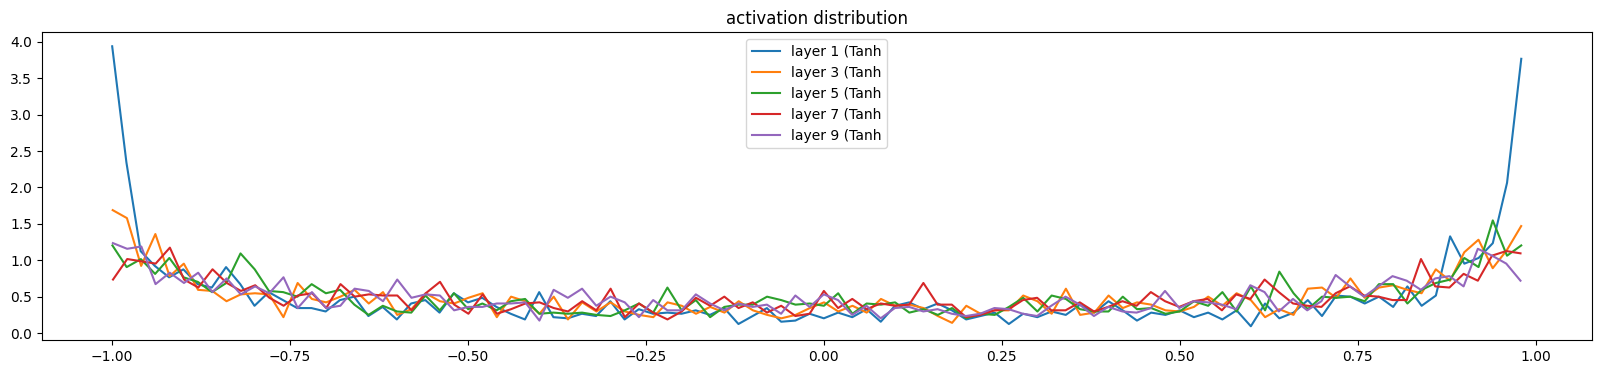

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # larghezza e altezza del grafico
legends = []
for i, layer in enumerate(layers[:-1]): # itera su tutti i layer. '-1' esclude l'output layer
  if isinstance(layer, Tanh): # se è un tanh layer
    t = layer.out # viene estratto l'output di ciascun layer
    # per ogni 't' misuriamo la media, deviazione standard e saturazione (ovvero % di valori oltre '0.97', ovvero quelli di maggiore attivazione, che potenzialmente stoppano i gradienti se troppi)
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True) # generazione dell'istogramma, con una linea per ogni layer (t)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

il grafico mostra una attivazione buona, che va nel tempo a stabilizzare la deviazione standard.

Se avessimo ridotto o addirittura rimosso il gain, esplicitato nella parte di codice seguente:

```
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # <- gain
```

i risultati sarebbero stati schiacciati ad ogni layer, la deviazione standard sarebbe diminuita sempre di più e la saturazione sarebbe andata a zero.

Utilizzando un gain troppo elevato, le attivazioni sarebbero invece state troppo forti (troppi valori sopra l'intervallo `-1, 1`), ovvero la saturazione sarebbe stata troppo alta, rischiando di disattivare alcuni neuroni.

<a name="s6.2"></a>
### **6.2 - Attivazioni durante il backward pass**

Possiamo analizzare anche il backward pass, studiando i gradienti. Anche in questo caso, la distribuzione dei gradienti nei vari strati è buona, ma sono molto sensibili al numero scelto per il gain.

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

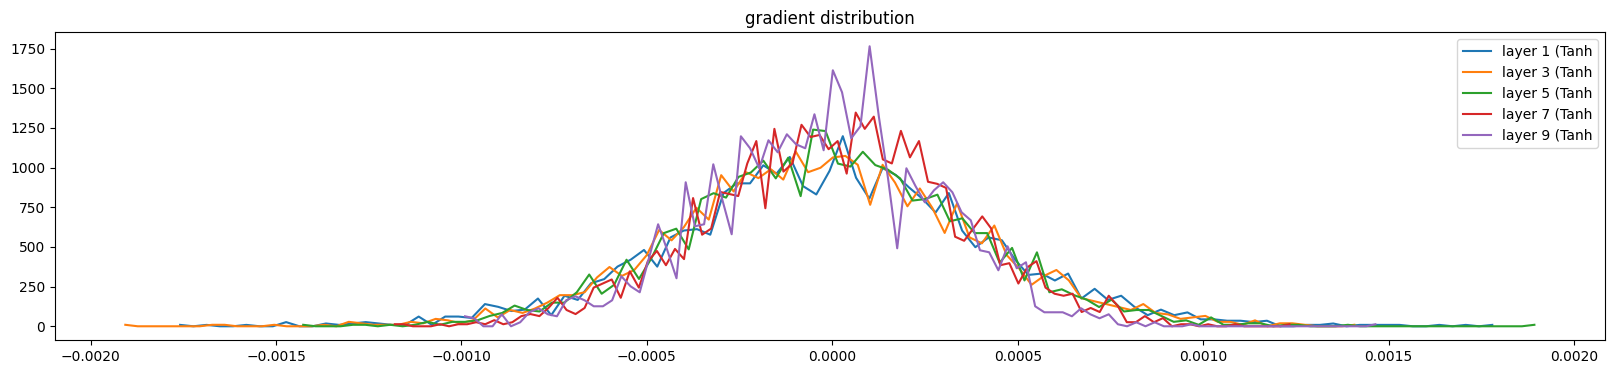

In [ ]:
# visualizziamo gli istogrammi
plt.figure(figsize=(20, 4)) # larghezza e altezza del grafico
legends = []
for i, layer in enumerate(layers[:-1]): # nota: esclude l'output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Questa analisi mira a mostrare la fragilità della rete in assenza di un layer di normalizzazione. Al variare del gain, l’efficacia dell’addestramento può cambiare drasticamente.

Con l’inclusione dei layer di normalizzazione (attualmente commentati nel codice dell'addestramento), la rete risulterebbe molto più resistente a queste variazioni. Invitiamo lo studente a sperimentare e verificare.

Per completare la nostra analisi dell'inizializzazione (ricordando che stiamo interrompendo l'addestramento dopo la prima iterazione), passiamo ora a esaminare un ulteriore grafico che fornisce informazioni utili per orientare la scelta dei parametri della rete.

<a name="s6.3"></a>
### **6.3 - Rapporto tra dato e gradiente**


Analizzeremo ora la distribuzione dei pesi per ciascun layer della rete, visualizzando sull'asse `x` i valori dei pesi e sull'asse `y` le rispettive frequenze.

Per comprendere meglio i risultati del grafico, stamperemo alcune informazioni utili che faciliteranno l'interpretazione:

- Valori dei pesi del layer

- Media dei valori dei pesi per il layer

- Deviazione standard dei valori dei pesi per il layer

- Rapporto tra il valore del gradiente e i valori effettivi dei dati (idealmente, i gradienti dovrebbero essere molto più piccoli dei valori dei dati)

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


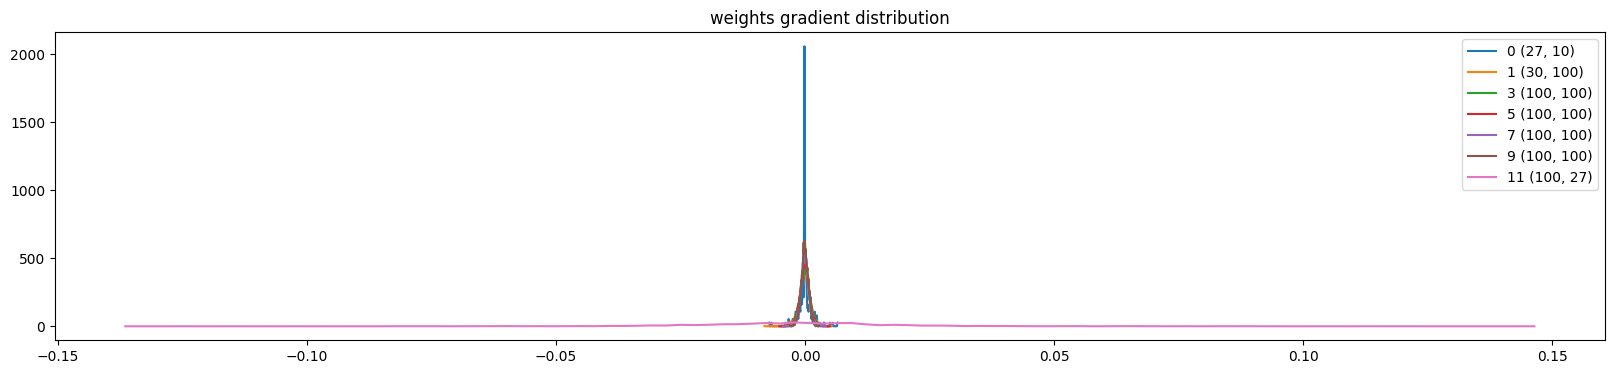

In [ ]:
# visualizziamo l'istogramma
plt.figure(figsize=(20, 4)) # larghezza e altezza del grafico
legends = []
for i,p in enumerate(parameters): # itera su tutti i parametri della rete
  t = p.grad
  if p.ndim == 2: # limitiamo l'analisi ai parametri che sono composti da due dimensioni, ovvero solamente i pesi della rete, per sempliciità di esposizione
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Come possiamo osservare, la rete appare abbastanza stabile, tranne che per l'output layer. Questo layer mostra un rapporto elevato tra il gradiente e i dati, indicando che i valori sono circa dello stesso ordine di grandezza. Inoltre, presenta una deviazione standard significativamente più alta (circa dieci volte superiore) rispetto agli altri strati. Questi valori suggeriscono che, all'inizializzazione, l'output layer si addestra circa dieci volte più velocemente rispetto agli altri strati.

Con il progredire dell'addestramento, questo effetto tende a ridursi. È possibile verificarlo tornando al codice e rimuovendo il commento a `if i >= 1000:` per osservare le differenze nel grafico, dove le code dell'ultimo layer apparirebbero più strette.

Questo squilibrio può essere affrontato con tecniche di aggiornamento dei gradienti più avanzate rispetto allo "Stochastic Gradient Descent (SGD)" che stiamo utilizzando attualmente. In lezioni successive, introdurremo ottimizzatori moderni come `Adam`, che gestiscono meglio questo tipo di problema.

<a name="s6.4"></a>
### **6.4 - Rapporto tra tasso di aggiornamento e dato**

Passiamo ora ad analizzare un grafico ancora più rappresentativo. Anziché confrontare il rapporto tra dato e gradiente (che è informativo solo in modo indiretto), possiamo rappresentare ciò che ci interessa davvero: il rapporto tra l'aggiornamento e il dato. Questo ci permette di osservare quanto effettivamente ogni dato venga modificato a ogni iterazione, offrendo una visione chiara di come i valori dei tensori cambiano durante l'addestramento.

Per fare ciò, riscriviamo il codice per l'addestramento, aggiungendo alcune istruzioni per tenere traccia di queste informazioni.

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # 'ud' sta per 'update to the data'

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    ''' aggiornamento di ogni parametro ad ogni iterazione: (learning rate * gradient) '''
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # con questo codice teniamo traccia del rapporto, ad ogni iterazione, senza salvare il grafo dei gradienti
  with torch.no_grad():
    '''
    il processo viene iterato per ciascun parametro:
    'lr*p.grad' è l'aggiornamento ad ogni iterazione (come definito sopra)
    'p.data' è il valore effettivo del parametro
    per ciascuno dei due calcoliamo la deviazione standard
    'log10' è per vedere i risultati nei grafici in maniera più chiara
    'ud.append' è per aggiungere le informazioni al tensore ud, per poi analizzarlo
    '''
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # il break serve a fare le analisi solamente all'inizializzazione, ovvero ad un solo forward e backward pass
# possiamo vedere anche i cambiamenti dopo qualche iterazione, ad esempio 1000
  if i >= 1000:
    break # AFTER_DEBUG: per avere l'intera ottimizzazione, ovviamente questa parte andrebbe rimossa

      0/ 200000: 3.2944


Creiamo il grafico:

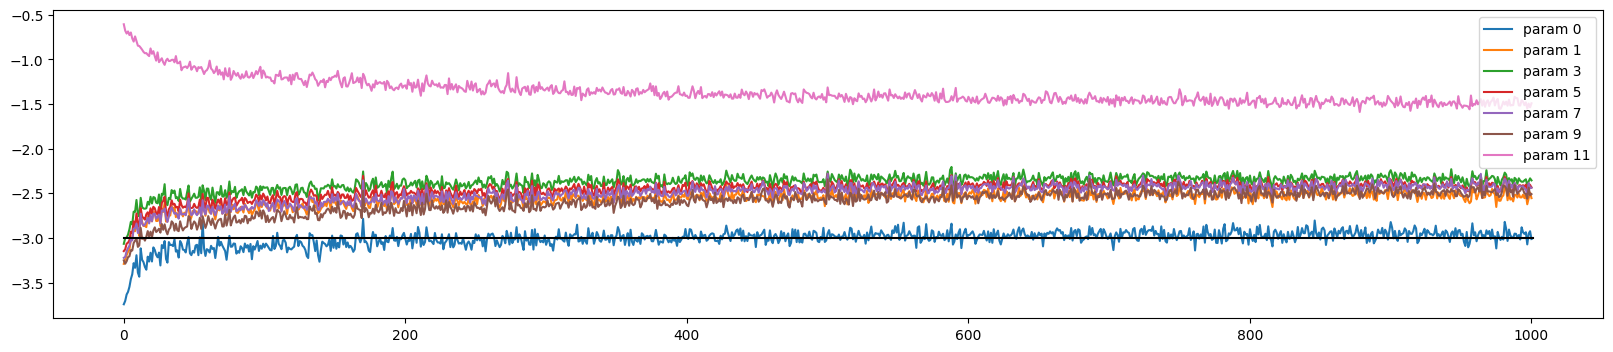

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # limitiamo il grafico ai parametri composti da 2 dimensioni, ovvero i pesi
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i) # carichiamo ud, aggiornandolo ad ogni iterazione (per ora impostato su 1000)
'''
aggiungiamo al grafico una linea che indica il valore che a grandi linee dovrebbe essere adatto,
ovvero 1/1000. I dati dovrebbero cambiare con un rapporto di 1 su 1000 rispetto al loro valore iniziale
'''
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


Dal grafico possiamo trarre diverse osservazioni:

1. Lo strato di output si comporta come un outlier, dato che abbiamo impostato manualmente che il risultato all'inizializzazione sia ridotto per evitare l'effetto 'mazza da hockey'. Possiamo vedere che nel tempo si stabilizza.


2. Il grafico consente di osservare se i vari strati apprendono alla stessa velocità o se ci sono differenze significative.


3. Se i valori sono molto sopra la linea di base che abbiamo impostato, significa che la rete sta apprendendo troppo rapidamente.


4. Se i valori sono molto al di sotto della linea di base, indica che la rete sta apprendendo troppo lentamente.


Naturalmente, il tasso di apprendimento può essere regolato manualmente, come abbiamo visto in precedenza.

In questo caso, il grafico mostra un comportamento complessivamente buono. Modificando alcuni parametri, è possibile fare dei test per osservare come i grafici cambino drasticamente con un tasso di apprendimento non ottimale.

<a name="s7"></a>
## **7 - Analisi approfondita con normalizzazione**

Vediamo ora come si trasformano i grafici introducendo lo strato di normalizzazione (Batch Normalization).

Reinizializziamo la rete, introducendo gli strati di normalizzazione:

In [ ]:
# Strato lineare
class Linear:

  def __init__(self, fan_in, fan_out, bias=True): # inizializzazione
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # inizializzazione dei pesi
    self.bias = torch.zeros(fan_out) if bias else None # bias inizializzati a zero

  def __call__(self, x): # se viene chiamato il modulo, esegue W @ X + b (se b non è nullo, altrimenti non lo somma)
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self): # restituisce i parametri del modello
    return [self.weight] + ([] if self.bias is None else [self.bias])


# Strato di batch normalization
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True # all'inizializzazione è settato su True, in modo che la media e la varianza utilizzati siano differenti in training rispetto al testing
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else: # ecco la differenza per quando non si utilizza "training", ovvero quando self.training = False
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta # differente da PyTorch, ma aggiunto per poter poi fare qualche grafico in maniera semplice
    # update the buffers
    if self.training:
      with torch.no_grad(): # non serve aggiornare i gradienti per questa parte, quindi non ha senso far mantenere le info per effettuare la back propagation
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# Non linearità
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return [] # questo strato non ha parametri

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

# È molto facile, ora, creare una rete, considerando che possiamo semplicemente far susseguire i vari strati

# una rete con la batch normalization sarebbe la seguente, per ora la lasciamo commentata per effettuare delle analisi

layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


with torch.no_grad():
  '''
  'layers[-1]' = ultimo layer: schiacciamo il risultato per impedire l'effetto mazza da hokey
  '''
  layers[-1].gamma *= 0.1 # con la normalizzazione schiacciamo i gamma (perché sono loro che si moltiplicano con l'output)
  #layers[-1].weight *= 0.1 # senza normalizzaizone schiacciamo i pesi

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # il gain si moltiplica all'output di ciascun layer lineare per farlo ricrescere un po' dopo essere schiacciato da tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True # tutti i parametri necessitano del gradiente

47024


Effettuiamo l'addestramento, per 1000 cicli:

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # 'ud' sta per 'update to the data'

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    ''' aggiornamento di ogni parametro ad ogni iterazione: (learning rate * gradient) '''
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # con questo codice teniamo traccia del rapporto, ad ogni iterazione, senza salvare il grafo dei gradienti
  with torch.no_grad():
    '''
    il processo viene iterato per ciascun parametro:
    'lr*p.grad' è l'aggiornamento ad ogni iterazione (come definito sopra)
    'p.data' è il valore effettivo del parametro
    per ciascuno dei due calcoliamo la deviazione standard
    'log10' è per vedere i risultati nei grafici in maniera più chiara
    'ud.append' è per aggiungere le informazioni al tensore ud, per poi analizzarlo
    '''
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # il break serve a fare le analisi solamente all'inizializzazione, ovvero ad un solo forward e backward pass
# possiamo vedere anche i cambiamenti dopo qualche iterazione, ad esempio 1000
  if i >= 1000:
    break # AFTER_DEBUG: per avere l'intera ottimizzazione, ovviamente questa parte andrebbe rimossa

      0/ 200000: 3.2870


Possiamo visualizzare i vari grafici, che avranno tutti delle buone distribuzioni:

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%
layer 2 (      Tanh): mean +0.000000, std 3.682959e-03
layer 5 (      Tanh): mean +0.000000, std 3.262612e-03
layer 8 (      Tanh): mean -0.000000, std 2.973733e-03
layer 11 (      Tanh): mean +0.000000, std 2.741114e-03
layer 14 (      Tanh): mean +0.000000, std 2.584294e-03
weight   (27, 10) | mean +0.000000 | std 1.019889e-02 | grad:data ratio 1.018849e-02
weight  (30, 100) | mean +0.000092 | std 8.238440e-03 | grad:data ratio 2.635842e-02
weight (100, 100) | mean +0.000031 | std 7.318122e-03 | grad:data ratio 4.377151e-02
weight (100, 100) | mean -0.000019 | std 6.662030e-03 | grad:data ratio 3.949900e-02
weight (100, 100) | mean -0.000019 | std 5.821521e-03 | grad:data ratio 3.46

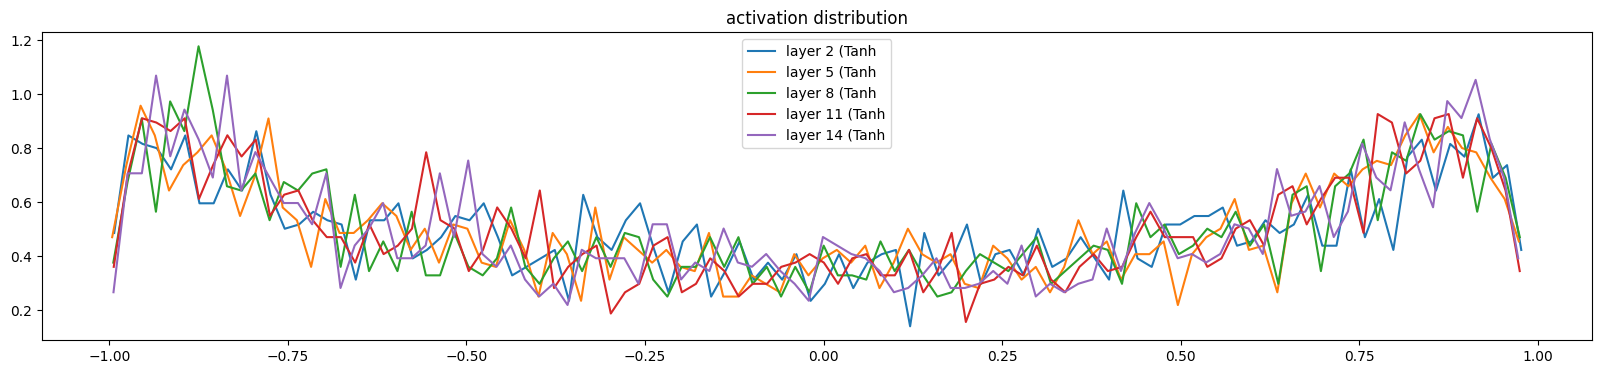

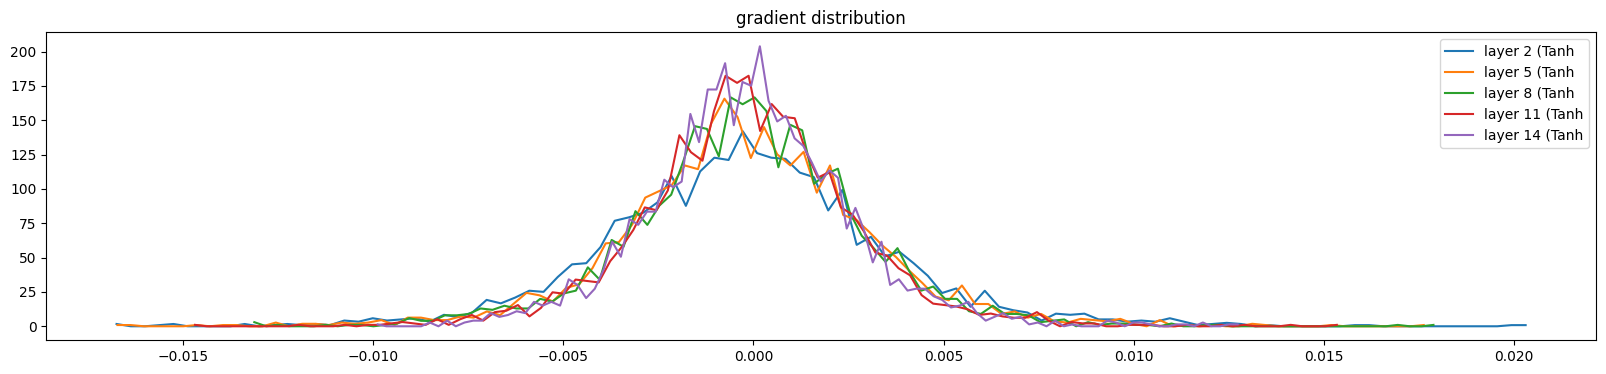

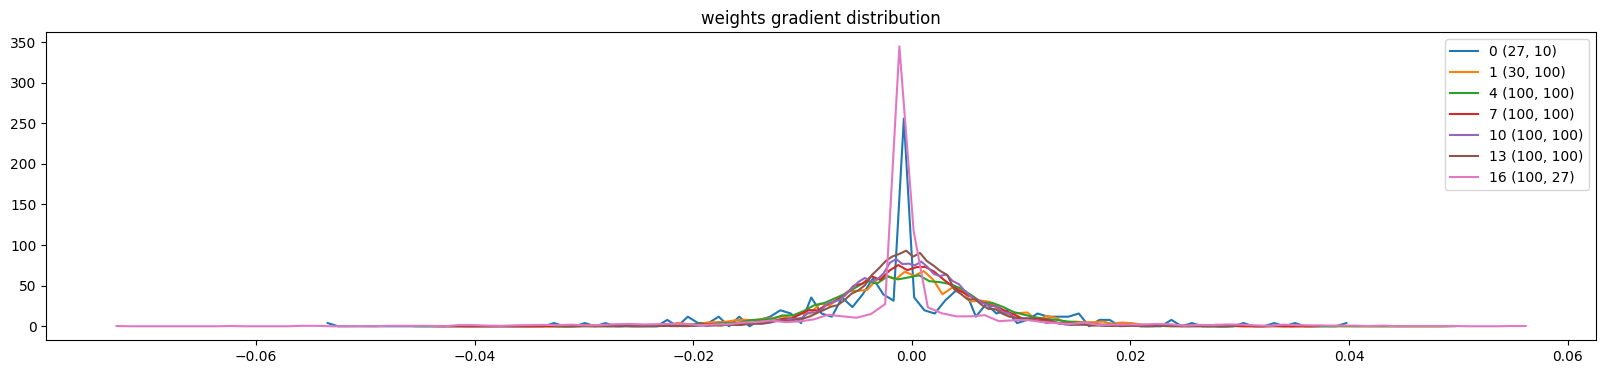

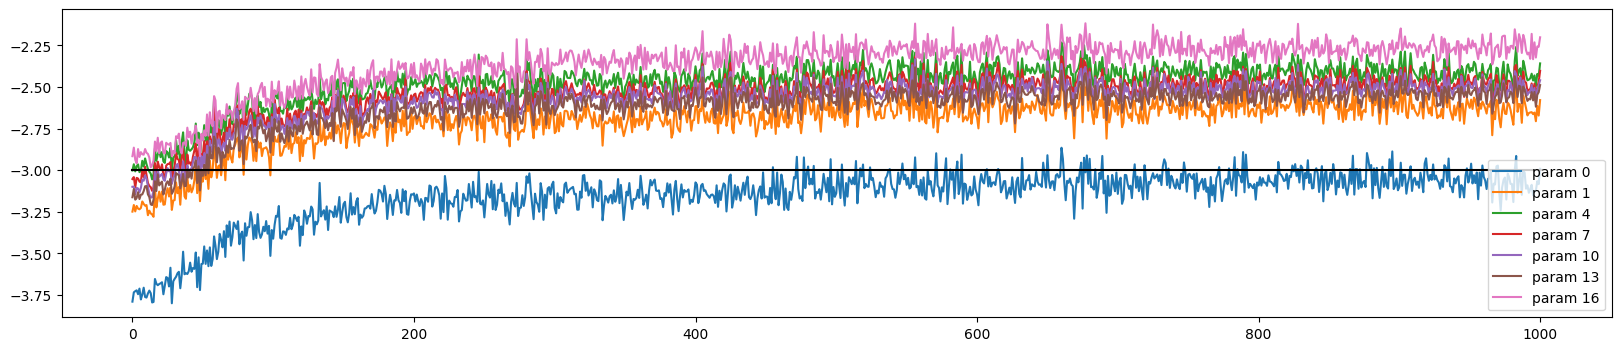

In [ ]:
# visualizza gli istogrammi
plt.figure(figsize=(20, 4)) # larghezza e altezza del grafico
legends = []
for i, layer in enumerate(layers[:-1]): # itera su tutti i layer. '-1' esclude l'output layer
  if isinstance(layer, Tanh): # se è un tanh layer
    t = layer.out # viene estratto l'output di ciascun layer
    # per ogni 't' misuriamo la media, deviazione standard e saturazione (ovvero % di valori oltre '0.97', ovvero quelli di maggiore attivazione, che potenzialmente stoppano i gradienti se troppi)
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True) # generazione dell'istogramma, con una linea per ogni layer (t)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters): # itera su tutti i parametri della rete
  t = p.grad
  if p.ndim == 2: # limitiamo l'analisi ai parametri che sono composti da due dimensioni, ovvero solamente i pesi della rete, per sempliciità di esposizione
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # limitiamo il grafico ai parametri composti da 2 dimensioni, ovvero i pesi
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i) # carichiamo ud, aggiornandolo ad ogni iterazione (per ora impostato su 1000)
'''
aggiungiamo al grafico una linea che indica il valore che a grandi linee dovrebbe essere adatto,
ovvero 1/1000. I dati dovrebbero cambiare con un rapporto di 1 su 1000 rispetto al loro valore iniziale
'''
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

<a name="s7.1"></a>
### **7.1 - Test con variazione del gain**

Possiamo ora fare un test: lo strato di normalizzazione dovrebbe rendere il processo di addestramento più robusto e quindi meno sensibile alle variazioni del moltiplicatore dei pesi. Proviamo a modificare il moltiplicatore dei pesi (ovvero il `gain`), passando ad esempio dal valore di `5/3` a `0.2`.

In [ ]:
# Strato lineare
class Linear:

  def __init__(self, fan_in, fan_out, bias=True): # inizializzazione
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # inizializzazione dei pesi
    self.bias = torch.zeros(fan_out) if bias else None # bias inizializzati a zero

  def __call__(self, x): # se viene chiamato il modulo, esegue W @ X + b (se b non è nullo, altrimenti non lo somma)
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self): # restituisce i parametri del modello
    return [self.weight] + ([] if self.bias is None else [self.bias])


# Strato di batch normalization
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True # all'inizializzazione è settato su True, in modo che la media e la varianza utilizzati siano differenti in training rispetto al testing
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else: # ecco la differenza per quando non si utilizza "training", ovvero quando self.training = False
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta # differente da PyTorch, ma aggiunto per poter poi fare qualche grafico in maniera semplice
    # update the buffers
    if self.training:
      with torch.no_grad(): # non serve aggiornare i gradienti per questa parte, quindi non ha senso far mantenere le info per effettuare la back propagation
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# Non linearità
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return [] # questo strato non ha parametri

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

# È molto facile, ora, creare una rete, considerando che possiamo semplicemente far susseguire i vari strati

# una rete con la batch normalization sarebbe la seguente, per ora la lasciamo commentata per effettuare delle analisi

layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


with torch.no_grad():
  '''
  'layers[-1]' = ultimo layer: schiacciamo il risultato per impedire l'effetto mazza da hokey
  '''
  layers[-1].gamma *= 0.1 # con la normalizzazione schiacciamo i gamma (perché sono loro che si moltiplicano con l'output)
  #layers[-1].weight *= 0.1 # senza normalizzaizone schiacciamo i pesi

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 0.2 # 5/3 # il gain si moltiplica all'output di ciascun layer lineare per farlo ricrescere un po' dopo essere schiacciato da tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True # tutti i parametri necessitano del gradiente

47024


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # 'ud' sta per 'update to the data'

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    ''' aggiornamento di ogni parametro ad ogni iterazione: (learning rate * gradient) '''
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # con questo codice teniamo traccia del rapporto, ad ogni iterazione, senza salvare il grafo dei gradienti
  with torch.no_grad():
    '''
    il processo viene iterato per ciascun parametro:
    'lr*p.grad' è l'aggiornamento ad ogni iterazione (come definito sopra)
    'p.data' è il valore effettivo del parametro
    per ciascuno dei due calcoliamo la deviazione standard
    'log10' è per vedere i risultati nei grafici in maniera più chiara
    'ud.append' è per aggiungere le informazioni al tensore ud, per poi analizzarlo
    '''
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # il break serve a fare le analisi solamente all'inizializzazione, ovvero ad un solo forward e backward pass
# possiamo vedere anche i cambiamenti dopo qualche iterazione, ad esempio 1000
  if i >= 1000:
    break # AFTER_DEBUG: per avere l'intera ottimizzazione, ovviamente questa parte andrebbe rimossa

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean +0.00, std 0.66, saturated: 2.00%
layer 8 (      Tanh): mean +0.00, std 0.66, saturated: 1.47%
layer 11 (      Tanh): mean +0.00, std 0.66, saturated: 1.22%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 0.72%
layer 2 (      Tanh): mean -0.000000, std 1.249226e-03
layer 5 (      Tanh): mean -0.000000, std 1.097230e-03
layer 8 (      Tanh): mean +0.000000, std 9.477235e-04
layer 11 (      Tanh): mean +0.000000, std 9.355879e-04
layer 14 (      Tanh): mean +0.000000, std 1.049950e-03
weight   (27, 10) | mean -0.000000 | std 7.373104e-03 | grad:data ratio 7.366225e-03
weight  (30, 100) | mean +0.000311 | std 1.391910e-02 | grad:data ratio 2.291524e-01
weight (100, 100) | mean +0.000029 | std 6.005445e-03 | grad:data ratio 2.009050e-01
weight (100, 100) | mean -0.000016 | std 5.219661e-03 | grad:data ratio 1.905846e-01
weight (100, 100) | mean -0.000050 | std 5.058508e-03 | grad:data ratio 1.92

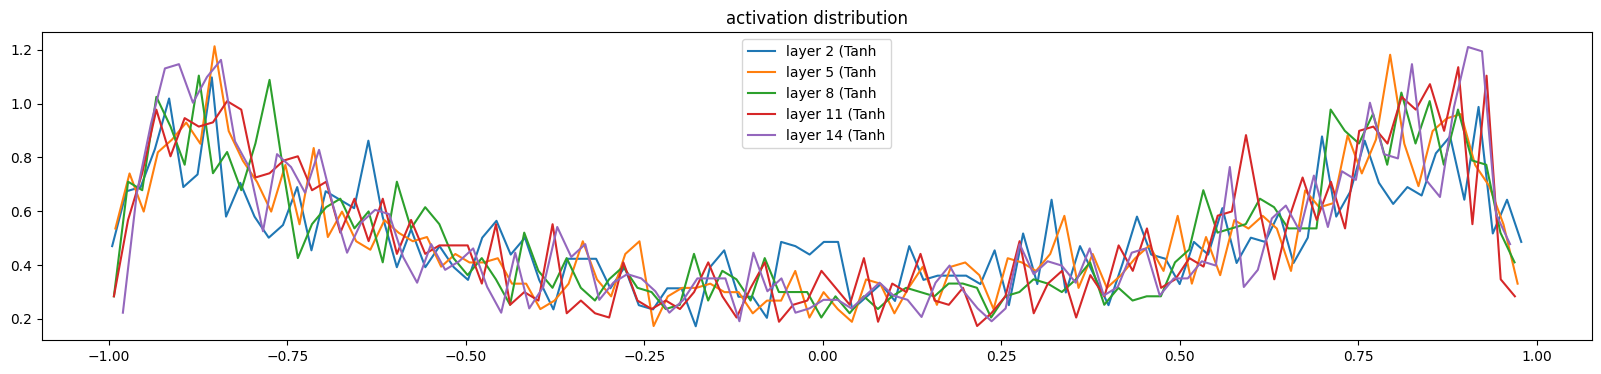

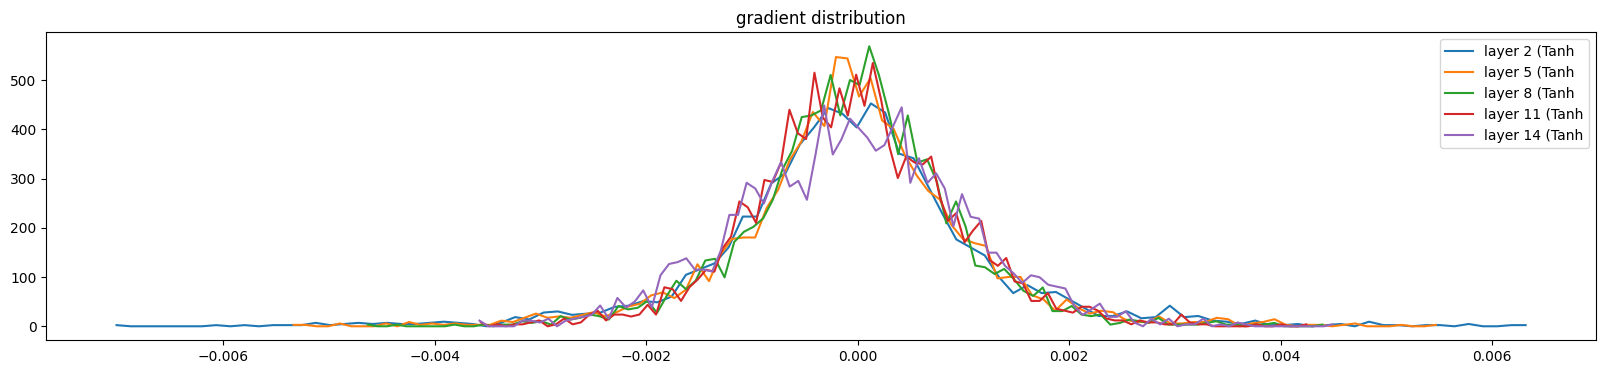

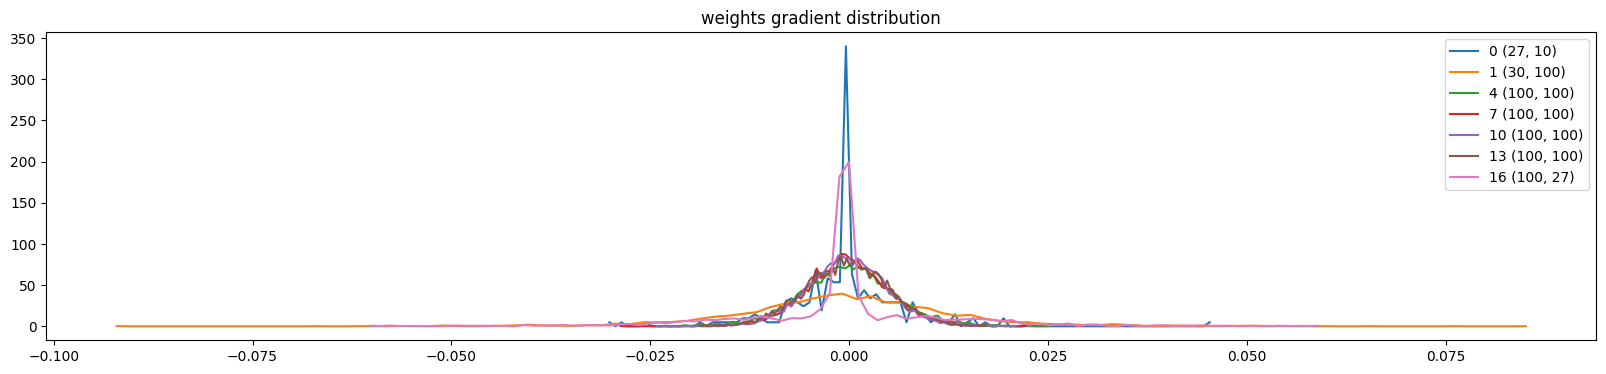

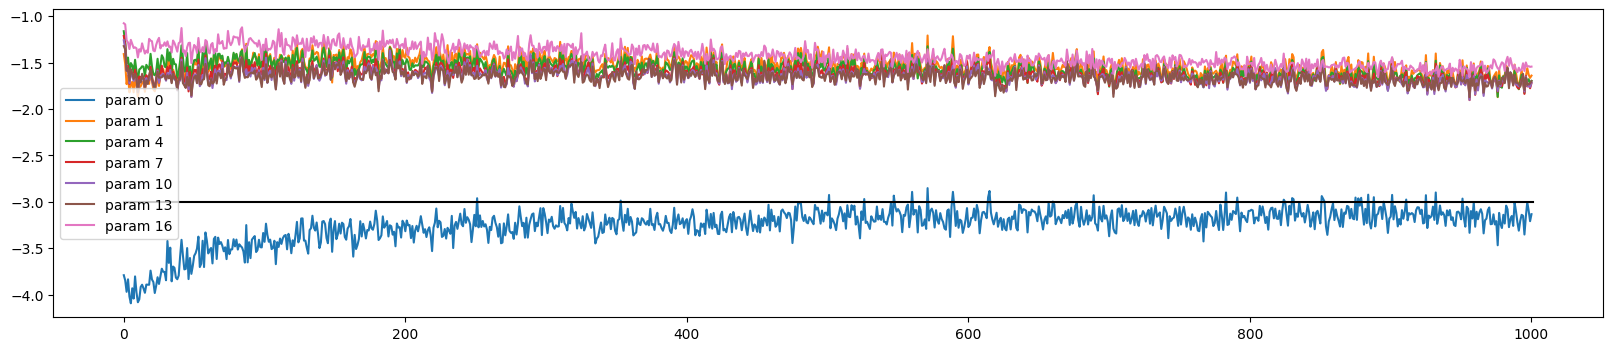

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # larghezza e altezza del grafico
legends = []
for i, layer in enumerate(layers[:-1]): # itera su tutti i layer. '-1' esclude l'output layer
  if isinstance(layer, Tanh): # se è un tanh layer
    t = layer.out # viene estratto l'output di ciascun layer
    # per ogni 't' misuriamo la media, deviazione standard e saturazione (ovvero % di valori oltre '0.97', ovvero quelli di maggiore attivazione, che potenzialmente stoppano i gradienti se troppi)
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True) # generazione dell'istogramma, con una linea per ogni layer (t)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters): # itera su tutti i parametri della rete
  t = p.grad
  if p.ndim == 2: # limitiamo l'analisi ai parametri che sono composti da due dimensioni, ovvero solamente i pesi della rete, per sempliciità di esposizione
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # limitiamo il grafico ai parametri composti da 2 dimensioni, ovvero i pesi
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i) # carichiamo ud, aggiornandolo ad ogni iterazione (per ora impostato su 1000)
'''
aggiungiamo al grafico una linea che indica il valore che a grandi linee dovrebbe essere adatto,
ovvero 1/1000. I dati dovrebbero cambiare con un rapporto di 1 su 1000 rispetto al loro valore iniziale
'''
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Come possiamo osservare, i primi tre grafici mantengono buone distribuzioni. L'ultimo grafico, invece, mostra un aumento significativo del tasso di aggiornamento.

Questo, tuttavia, non rappresenta un problema: basterebbe infatti regolare il learning rate per compensare, poiché per tutte le altre metriche non si riscontrano problemi.


---

Potremmo persino rimuovere la normalizzazione iniziale fan_in, eliminando `/ fan_in**0.5` nella sezione:

```
self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5  # inizializzazione dei pesi
```

Il risultato si comporterebbe in modo simile, richiedendo solo un aggiustamento del learning rate.

---

<a name="sconcl"></a>
## **Conclusioni**

Questa lezione aveva tre obiettivi principali. In primo luogo, introdurre la **normalizzazione batch (Batch Normalization)**, una delle prime innovazioni moderne nel campo delle reti neurali profonde che ha contribuito a stabilizzare il processo di addestramento di queste reti. È stato illustrato in dettaglio il funzionamento della normalizzazione batch e come questa possa essere integrata in una rete neurale per migliorarne le prestazioni. L'importanza di comprendere il suo utilizzo e la sua applicazione pratica è fondamentale per chi lavora con reti neurali profonde.

In secondo luogo, **ottimizzare il codice utilizzando PyTorch**, trasformando i componenti delle reti neurali in moduli riutilizzabili, come `Linear`, `BatchNorm1D`, `Tanh`, e così via. Questi moduli sono stati concepiti come strati che possono essere impilati per creare reti neurali, paragonati a mattoncini Lego che consentono di costruire architetture complesse. Il codice è stato sviluppato per rispecchiare l'API di PyTorch, permettendo una transizione fluida tra il codice personalizzato e PyTorch stesso: basta anteporre `nn.` ai moduli definiti, e tutto funziona in maniera identica. Questa compatibilità semplifica l'utilizzo di PyTorch per chiunque voglia implementare reti neurali in maniera efficiente e modulare.

Il terzo obiettivo era quello di **introdurre strumenti diagnostici** per valutare lo stato delle reti neurali durante l'addestramento. Sono stati analizzati vari aspetti, come le statistiche sulle attivazioni del forward pass, i gradienti del backward pass, e i pesi che vengono aggiornati nel processo di ottimizzazione mediante discesa del gradiente stocastica. Un aspetto cruciale è stato l'esame delle medie e delle deviazioni standard, nonché il rapporto tra gradienti e dati, e tra aggiornamenti e dati. Abbiamo visto che l'osservazione di questi rapporti nel tempo è un metodo efficace per diagnosticare il buon funzionamento della rete.

Nonostante questi progressi, vi sono alcuni aspetti che non sono stati trattati in modo approfondito. Ad esempio, **non è stato tentato di superare le prestazioni ottenute in precedenza** utilizzando la normalizzazione batch. I risultati ottenuti con la normalizzazione batch sono stati difatti molto simili a quelli precedenti. Ciò è dovuto al fatto che le prestazioni attuali non sono limitate dall'ottimizzazione, che è ciò che la normalizzazione batch mira a migliorare, ma piuttosto dalla lunghezza del contesto. Il modello, infatti, utilizza un contesto di tre caratteri per prevedere il quarto, e per ottenere risultati migliori sarebbe necessario esplorare architetture più avanzate, come le **reti neurali ricorrenti** o i **Transformers**, per estendere il contesto e migliorare ulteriormente le probabilità logaritmiche ottenute su questo dataset.

Infine, **non è stata fornita una spiegazione completa** del funzionamento delle attivazioni, dei gradienti e del backward pass, né è stato esplorato in dettaglio come questi meccanismi interagiscono con l'inizializzazione della rete e con la back propagation. Sebbene alcune parti possano essere risultate poco intuitive, soprattutto riguardo alla relazione tra il gain dei pesi e la necessità di regolare il tasso di apprendimento, la lezione non aveva l'obiettivo di fornire una comprensione profonda di tutti questi aspetti. L'intento era piuttosto quello di introdurre strumenti diagnostici di base per monitorare il comportamento della rete, lasciando l'approfondimento teorico ad altri contesti.